<a href="https://colab.research.google.com/github/mujtabenator/Traveltide/blob/main/TravelTide_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Libraries & Cohort User Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler # for scaling the data


In [ ]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set the ggplot style
plt.style.use('ggplot')

# Load the dataset
cohort_users = pd.read_csv('/content/TravelTide_final.csv')

**Introduction:**
This is an Exploratory Data Analysis for TravelTide, a fictional e-booking startup. Our primary objective is customer segmentation with the end goal of determining suitable perks to enhance customer retention. This notebook presents the initial phase of our analysis using Python, encompassing data understanding, cleaning, and preparation for subsequent analytical steps. The following data is the outcome of a SQL query that joined four tables:

Table 1. Users: user demographic information

Table 2. Sessions: information about individual browsing sessions

Table 3. Flights: information about purchased flights

Table 4. Hotels: information about purchased hotel stays

Cohort: Based on Marketing Manager's request we included sessions starting after the New Years holiday (2023-01-04) until the last available date in the database (2023-07-23), and only include the users with more than 7 sessions during the same time period. This lets us analyze customer behaviour within a fixed time frame.

Following up on our meeting with the Marketing Manager of the company, these are the perks most likely to attract customers:

Free hotel meal.

Free checked bag.

No cancellation fees.

Exclusive discounts.

1-night free hotel with a flight.

## Data Understanding and handling Null values

In [ ]:
cohort_users.shape

(5998, 31)

In [ ]:
# check for missing values
cohort_users.isna().sum()

user_id                                      0
sign_up_date                                 0
age                                          0
gender                                       0
married                                      0
has_children                                 0
home_country                                 0
home_city                                    0
session_count                                0
avg_session_duration_minute                  0
avg_page_clicks                              0
total_trips                                  0
conversion_rate                              0
weekend_trip_proportion                      0
cancellation_proportion                    432
avg_booking_departure_gap_days_flights     792
avg_booking_departure_gap_days_hotels      563
total_flights_booked                         0
round_trips_proportion                       0
avg_flight_price_usd                       792
avg_flight_discount_amount                1277
discounted_fl

I can see an interesting pattern in the number of null values, we have the same number of null values related to flights (booking_departure_gap_days_flights, avg_flight_price_usd, avg_flight_seats, avg_checked_bags, avg_distance_flown_km), and the same number of null values related to hotels (booking_departure_gap_days_hotels, avg_hotel_price_usd, avg_hotel_rooms, avg_stay_duration_day). That's good! Because not all the users booked both flights and hotels together.

Also, we got some null values for cancellation_proportion, avg_flight_discount_amount and avg_hotel_discount_amount that also make sense, not all users got discounts for their bookings.

Given that we're planning to implement Customers Segmentation and we want to create some new metrics using the existed features, the approach to handle null values and data transformation becomes very crucial.

Let's check out one by one the meaning of null values in each column and based on that decide how to deal with it:

**1. Cancellation_proportion:**

Meaning of NULL: The user hasn't booked any trip.


Meaning of 0: The user has booked at least one trip and has not cancelled any.


I will use this feature later in calculating the last_min_booker_index alongside avg_booking_departure_gap_days. We want to use the index at the end for offering the No cancellation fee perk, so Higher cancellation_proportion and Lower avg_booking_departure_gap_days are in our favour.


My approach for calculating the last_min_booker_index will be the weighted sum, so I want to ensure that null values in the cancellation_proportion don't distort or unfairly impact the index.


Considering that a null in cancellation_proportion means the user hasn't booked any trip, and a value of 0 means the user booked but didn't cancel any trip, here's my approach:


Fill with a Neutral Value: If the user hasn't booked any trip (i.e., null in cancellation_proportion), we can consider it neutral from a cancellation perspective. It's neither good nor bad from a propensity to cancel viewpoint since they never engaged in the act of booking to begin with. With this, both users who haven't booked and those who booked but didn't cancel will have the same value (0) in cancellation_proportion. The distinction is subtle, but from the perspective of cancellation propensity, they are functionally similar.


Flagging:

Even after filling null values with 0, we might still want to differentiate between users who never booked and those who booked but didn't cancel. To capture this I will also create a binary column (has_booked) that is True for users who have booked (whether they cancelled or not) and False for users who never booked. Later if we ever need to differentiate or analyze these user groups separately, we can use the has_booked flag.

In [ ]:
# flagging users based on flight bookings:True if the user has booked a flight and False if hasn't
cohort_users['has_booked'] = ~cohort_users['cancellation_proportion'].isna()

# filling cancellation_proportion column null values with 0
cohort_users['cancellation_proportion'].fillna(0, inplace=True)

**2. avg_booking_departure_gap_days_flights and avg_booking_departure_gap_days_hotels:**

The booking to departure gap time in days metrics are the result of the difference between the end of the user's browsing session and flight departure time / hotel check-in time. I added the hotel check-in time as not all the members have booked both hotel and flights together. If you check you'll see, in the case of having both metrics, the flight one is bigger than the hotel one. So before deciding what to do with their null values, I'll combine these two columns by keeping the bigger amount.

In [ ]:
# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_booking_departure_gap_days_hotels') + 1

# Insert the new column which is the maximum of the both columns at the desired position
cohort_users.insert(position, 'avg_booking_departure_gap_days',
            cohort_users[['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels']].max(axis=1))

# Drop the original columns
cohort_users.drop(columns=['avg_booking_departure_gap_days_flights', 'avg_booking_departure_gap_days_hotels'], inplace=True)

In [ ]:
# check the number of null values of the new column 'avg_booking_departure_gap_days'
null_values = cohort_users['avg_booking_departure_gap_days'].isna().sum()
print(f'We have {null_values} null values in avg_booking_departure_gap_days column.')

We have 432 null values in avg_booking_departure_gap_days column.


**Considerations for handling null values:**


**Meaning of Null:** User hasn't booked either a flight or hotel.


Nature of Data: This column represents a time duration between booking time and departure time. The more significant this value, the earlier a user books. A smaller value indicates last-minute bookings.


As I already have mentioned I will use this column in calculating last_min_booker_index alongside cancellation_proportion. In the formula, we will subtract this value from the maximum gap in the dataset. It means that smaller values (indicative of last-minute bookings) will yield a higher contribution to the index.


For users who haven't booked, their tendency to be last-minute bookers is technically unknown. They neither booked early nor late. We need a strategy that neither penalizes nor rewards these users disproportionately in the final index.


**Approach for Null Handling:**


Max Value Imputation: Given our formula for the index, users with the highest avg_booking_departure_gap_days (i.e., those who book well in advance) would contribute the least to the index. To ensure users who haven't booked don't get undue advantages or disadvantages in the index, one can impute their gaps with this maximum value.By using the maximum value, users who haven't booked essentially get a neutral score in the last_min_booker_index calculation. They're neither treated as early bookers nor last-minute bookers.


**Flagging:** We already flagged users based on the cancellation_proportion column (with has_booked), that flag also indirectly captures the users who haven't booked a flight or hotel.

In [ ]:
max_gap = cohort_users['avg_booking_departure_gap_days'].max()
cohort_users['avg_booking_departure_gap_days'].fillna(max_gap, inplace=True)

**3. Flight-related columns:**

**avg_flight_price_usd, avg_flight_discount_amount, avg_flight_seats, avg_checked_bags, and avg_distance_flown_km**


**Meaning of Null: **User hasn't booked a flight / in case of the avg_flight_discount_amount user either hasn't booked a flight or hasn't received a discount in flight bookings.


I will use these columns later to create new metrics. Starting with average dollar saved per kilometer I will use the following formula:


avg_usd_saved_per_km = avg_flight_discount_amount * avg_flight_price_usd / avg_distance_flown_km


Then I'll use it to calculate another index, bargain_hunting_index using the weighted average method which will be used for categorising our price-sensitive customers to offer Exclusive Discounts perk.


**Approach for Null Handling:**


The approach should prioritize preserving the meaningfulness of the derived metrics and not introducing unnecessary bias in the final index.


**Flagging: **We flag the users who haven't booked a flight. This will always give us the flexibility to handle them differently in subsequent analyses if necessary.


**avg_flight_discount_amount:** Since it represents the average discount amount the user received on flights, a null value indicates the user never booked a flight and hence never received a discount. Given that we're using it directly in the bargain_hunting_index and in the avg_usd_saved_per_km metric, it's reasonable to set the null values to zero. It implies they saved nothing, which is accurate.


**avg_distance_flown_km:** We're using this column to calculate avg_usd_saved_per_km. If it is zero or null, the metric becomes undefined. A zero value for avg_distance_flown_km would imply infinite savings (division by zero), which is misleading. Instead, we replace null values in this column with its medians. This will have the effect of assigning users who haven't flown a value of avg_usd_saved_per_km that is representative of an average user. This assumes that had they flown, their behavior might have been average.


**avg_flight_price_usd:** Using zero would suggest that a user booked a flight for free, which could be misleading and skew the data analysis. Using the median would imply the user has a typical spending pattern for flights, even though they haven't booked one. This method carries the assumption that if they were to book, their booking price would be close to the median.


**avg_flight_seats & avg_checked_bags:** These metrics, represent the average number of seats booked and checked_bag per flight, and are likely indicative of the group size. A higher value implies group or family bookings. We will need to use them later in calculating indexes for Free hotel meal and Free checked bag. Fill the null values in both columns with 0 directly represents that they haven't booked any seats or had a checked bag. Given that higher values are more attractive for the mentioned perks, this approach will naturally rank non-flyers lower, which aligns with the logic I mentioned.

In [ ]:
# Flag users who haven't booked a flight
cohort_users['has_booked_flight'] = ~cohort_users['avg_flight_price_usd'].isna()

# Columns to fill with 0
zero_fill_columns = ['avg_flight_discount_amount', 'avg_flight_seats', 'avg_checked_bags']

# Columns to fill with their medians
median_fill_columns = ['avg_flight_price_usd', 'avg_distance_flown_km']

# filling null values with zero
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# filling null values with median
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

**4. Hotel-related columns:**

**avg_hotel_price_usd, avg_hotel_discount_amount, avg_hotel_rooms, and avg_stay_duration_day**


**Meaning of Null: ** User hasn't booked a hotel / in case of the avg_hotel_discount_amount user either hasn't booked a hotel or hasn't received a discount in hotel bookings.


I will use these columns later to create new metrics. I already mentioned the bargain_hunting_index where avg_hotel_discount_amount will be used alongside other metrics.


As I also already mentioned we are going to calculate an index to help us to segment the users to offer Free hotel meal and Free checked bags. avg_hotel_rooms and avg_hotel_price_usd will be used there alongside other metrics. Higher avg_hotel_rooms and lower avg_hotel_price_usd will be in our favor. Higheravg_stay_duration_day also will support the calculation of the index.


**Approach for Null Handling:**


**Flagging:** Like before we flag the users who haven't booked a hotel. Given the context and the usage of the columns, here's how we can handle null values:


**avg_hotel_price_usd:** Using zero would suggest that a user booked a hotel for free, which could be misleading and skew the data analysis. Using the median would imply the user has a typical spending pattern for hotels. This method carries the assumption that if they were to book, their booking price would be close to the median.


**avg_hotel_discount_amount:** Null values mean that the either user hasn't booked a hotel and thus hasn't received any discount, or has booked but again didn't receive a discount. This can be filled with 0 as it signifies that the user didn't save anything on hotel bookings. This will support the "bargain_hunting_index" calculation, as users who haven't availed any discounts would be at the lower end of the index.

**avg_hotel_rooms:** If a user hasn't booked a hotel, it means they've booked 0 rooms. Filling null values with 0 makes sense for this column.

**avg_stay_duration_day:** A user that hasn't booked a hotel hasn't stayed any number of days. It's logical to fill the null values with 0 in this context. This is particularly important as we're associating longer stays with **free checked bags** perk.

In [ ]:
# Flag users who haven't booked a hotel
cohort_users['has_booked_hotel'] = ~cohort_users['avg_hotel_price_usd'].isna()

# Columns to fill with 0
zero_fill_columns = ['avg_hotel_discount_amount', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Columns to fill with their medians
median_fill_columns = ['avg_hotel_price_usd']

# filling null values with zero
for col in zero_fill_columns:
    cohort_users[col].fillna(0, inplace=True)

# filling null values with median
for col in median_fill_columns:
    cohort_users[col].fillna(cohort_users[col].median(), inplace=True)

# checking the number of null values
null_values = cohort_users.isna().sum().sum()
print(f'We have {null_values} Null values in the dataset.')

We have 0 Null values in the dataset.


**Check statistical summary:**

Before creating new metrics, we need to scale the existed features, and before that we have to check our outliers and treat them.

In [ ]:
# Excluding user_id column as it doesn't make sense to get its statistical summary
selected_columns = cohort_users.columns.difference(['user_id'])

# Generate the statistical summary for selected columns
cohort_users[selected_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,5998.0,41.828109,12.045491,17.00,35.00,42.000,49.0000,89.00
avg_booking_departure_gap_days,5998.0,46.304813,99.703231,1.50,6.99,8.240,10.6200,365.08
avg_checked_bags,5998.0,0.523671,0.519474,0.00,0.00,0.500,1.0000,6.60
avg_distance_flown_km,5998.0,2302.206816,1633.915771,27.52,1554.83,2000.040,2543.1975,15954.76
avg_flight_discount_amount,5998.0,0.110989,0.085397,0.00,0.05,0.100,0.1500,0.55
avg_flight_price_usd,5998.0,529.420250,691.082171,5.35,300.82,392.795,528.2425,14280.38
avg_flight_seats,5998.0,1.061144,0.591982,0.00,1.00,1.000,1.2500,6.60
avg_hotel_discount_amount,5998.0,0.076164,0.068848,0.00,0.00,0.080,0.1000,0.45
avg_hotel_price_usd,5998.0,176.839388,80.723534,24.00,128.00,163.000,205.3200,1063.00
avg_hotel_rooms,5998.0,1.085792,0.484330,0.00,1.00,1.000,1.2500,4.00


I see an odd minimum value for the avg_stay_duration_day column, which is -1! I went back to the database and wrote a few SQL queries to check the hotel's table, and it seems these ones are errors. As I saw the check_out_time was before the check_in_time. Let's see how many of the records got negative amount:

In [ ]:
negative_numbers = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]
percentage = round(cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]/
                   cohort_users.avg_stay_duration_day.count()*100,2)
print(f'Only {negative_numbers} records ({percentage}%) of avg_stay_duration_day column have negative amounts.')

Only 2 records (0.03%) of avg_stay_duration_day column have negative amounts.


Well, that's not big. But as it's the average stay duration, I went back to my SQL queries and checked how many records we had in the whole cohort (one by one not average), and it's only 15 records out of 5998. So that would be not a concern.

I also checked the number of records that have the <= 0 amount in their stay duration, and it's 1749 records. But that's understandable, as the users might check_in/check_out so late that the difference between check_out and check_in time would be zero days.

I'll replace that two records with 0.

In [ ]:
# replacing the records with 0
cohort_users.loc[cohort_users['avg_stay_duration_day'] < 0, 'avg_stay_duration_day'] = 0

negative_numbers = cohort_users[cohort_users['avg_stay_duration_day'] < 0].shape[0]

# checking how many records we have with this criteria
print(f'Now {negative_numbers} records of the avg_stay_duration column is negative.')

Now 0 records of the avg_stay_duration column is negative.


### Outliers Removal:

Checking the statistical summary, most columns show relatively close numbers in mean and median. Let's check the distribution by plotting them on a histogram. To gain a more comprehensive understanding of our data's distribution and the presence of outliers, we'll plot a box plot:


**Note:** I set an outlier definition equal to **five standard deviations** away from the sample mean. 5 standard deviations is a 1 in 500 million event under the assumption of normality, so we reason these data are pretty unlikely!

I wrote a function to plot the histogram of all numeric columns (except the user_id), and I used **Sturge's formula** to calculate the **number of bins** for each chart, to avoid having a fixed number of bins for each.

For calculating the number of bins, besides the **Sturge's formula**, I tried Square-root Rule, **Rice Rule**, and **Freedman-Diaconis Rule** and the outcome of **Sturge's formula** was the best, the rest gave a very noisy outcome with many bins. It could be better to manually input the number of bins for each column, but that wouldn't be very ideal.

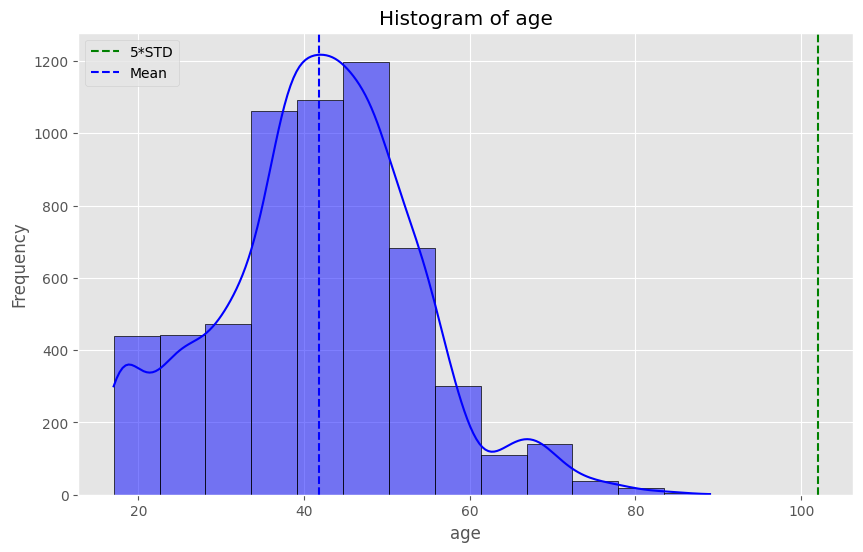

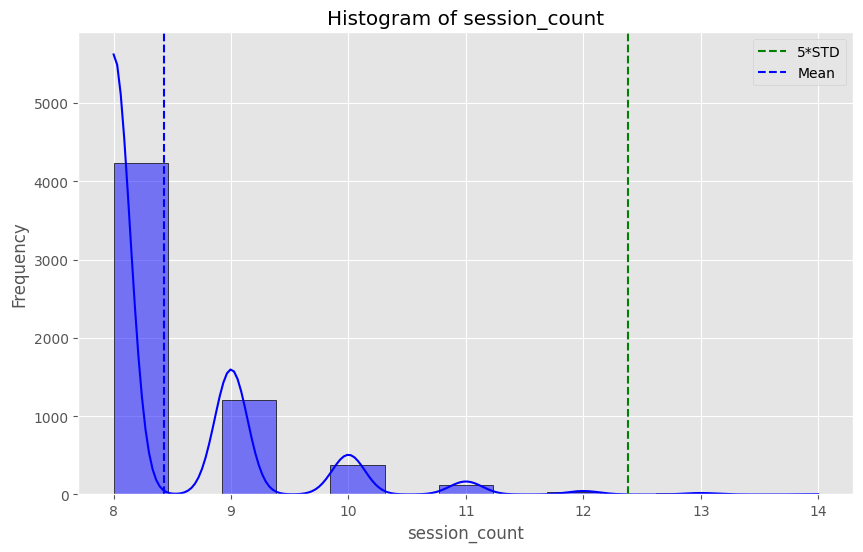

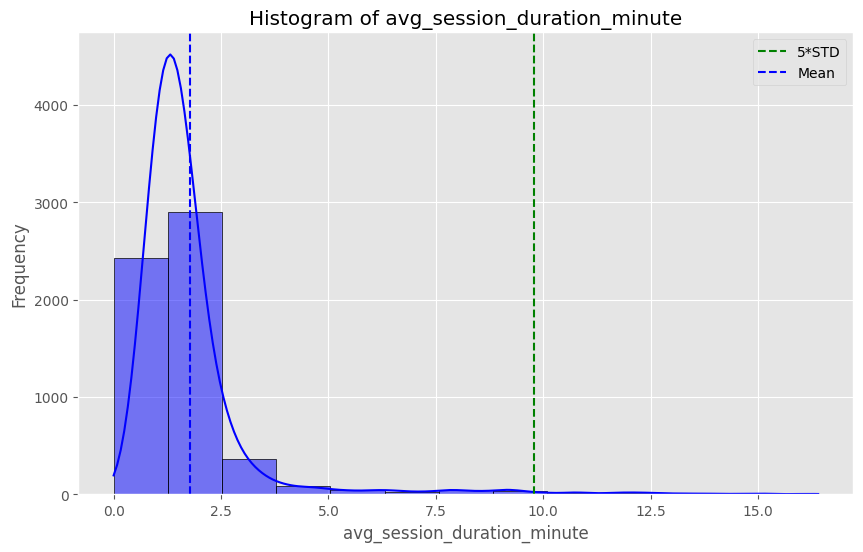

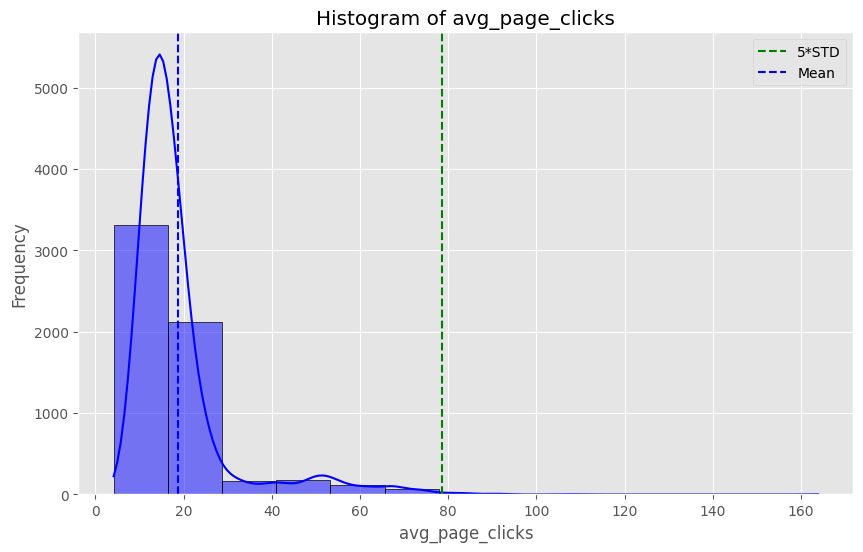

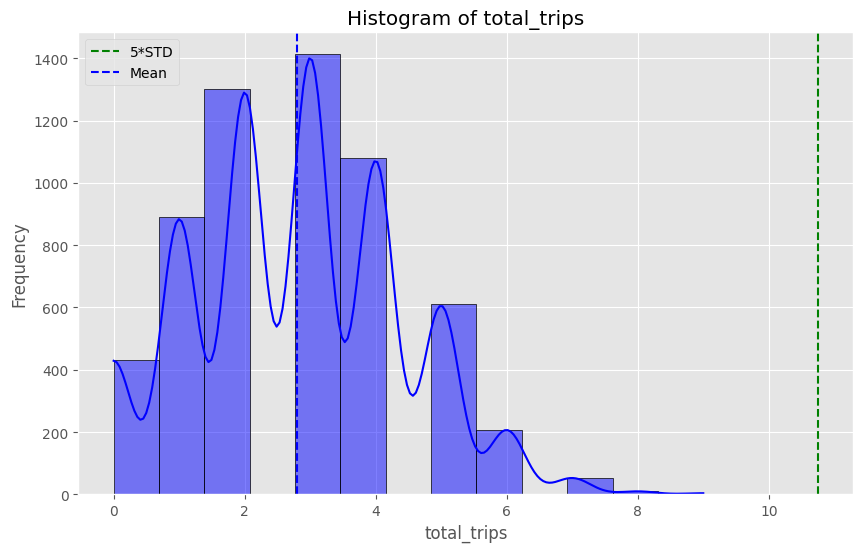

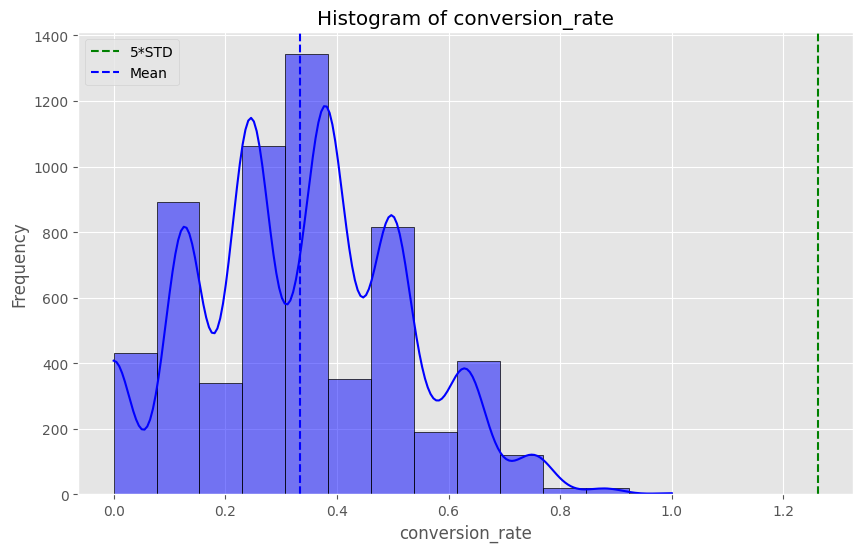

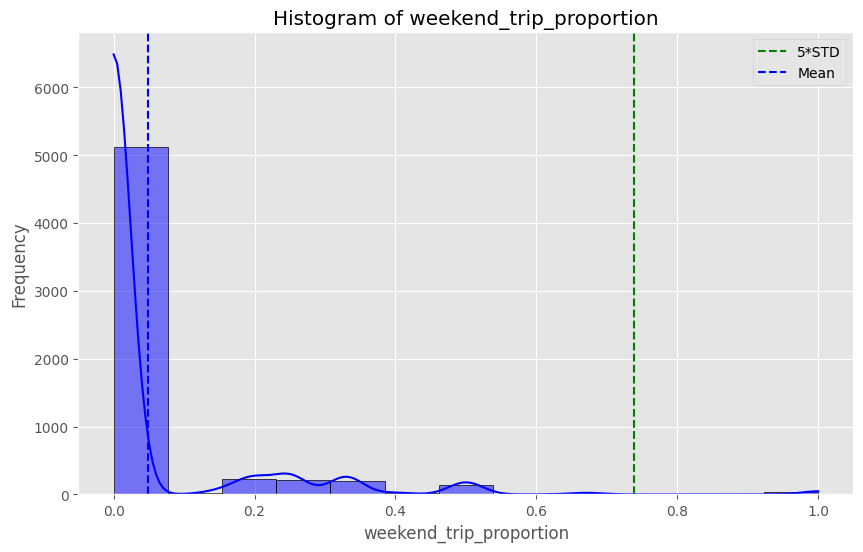

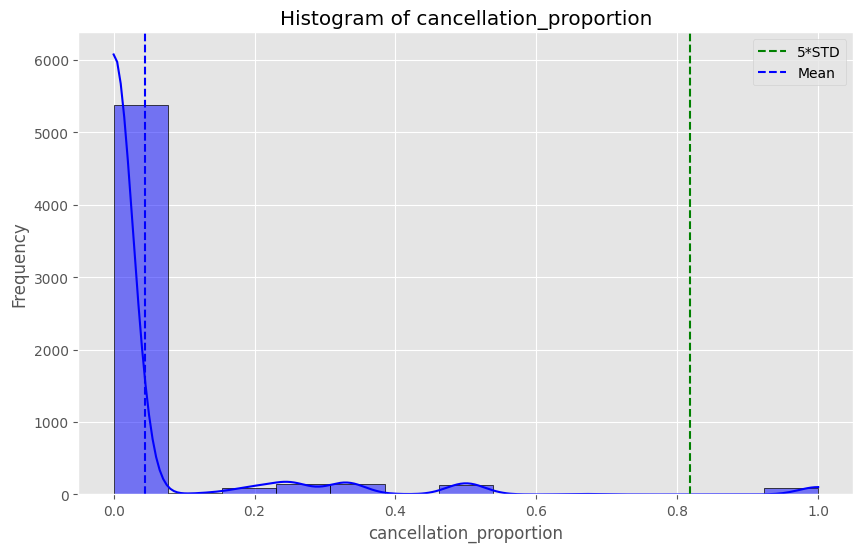

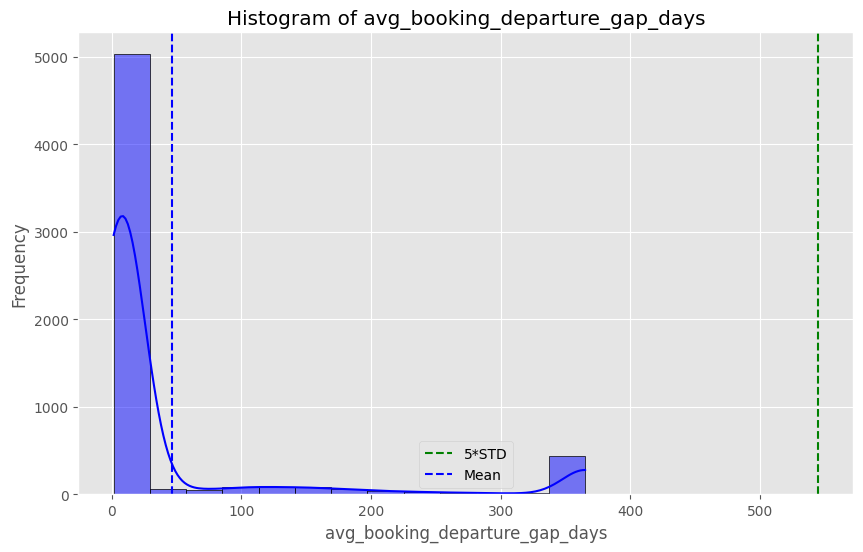

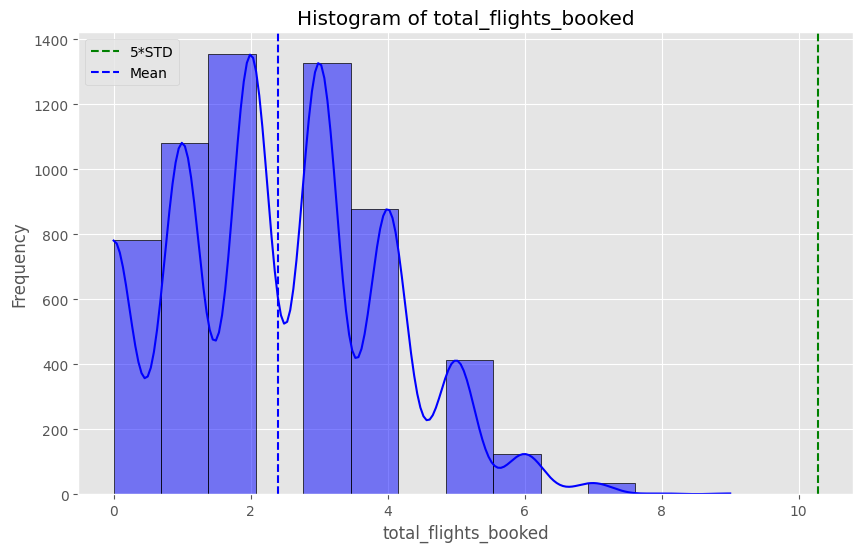

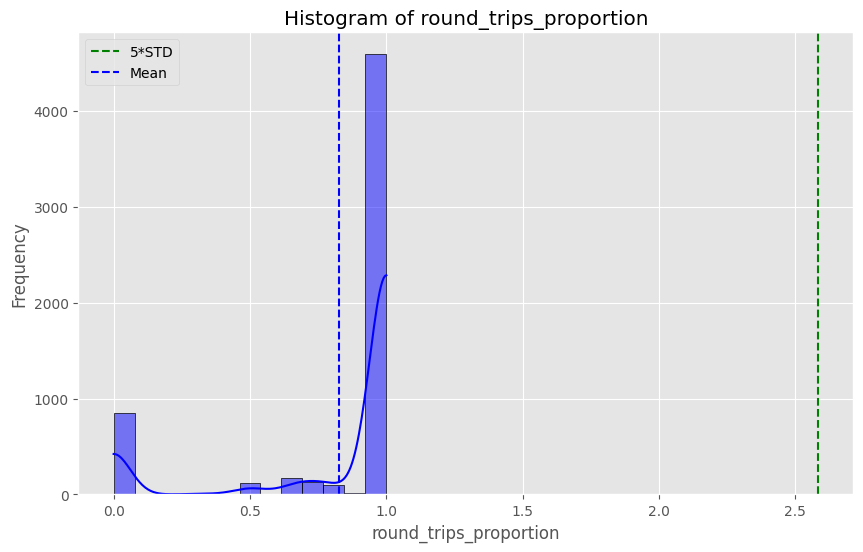

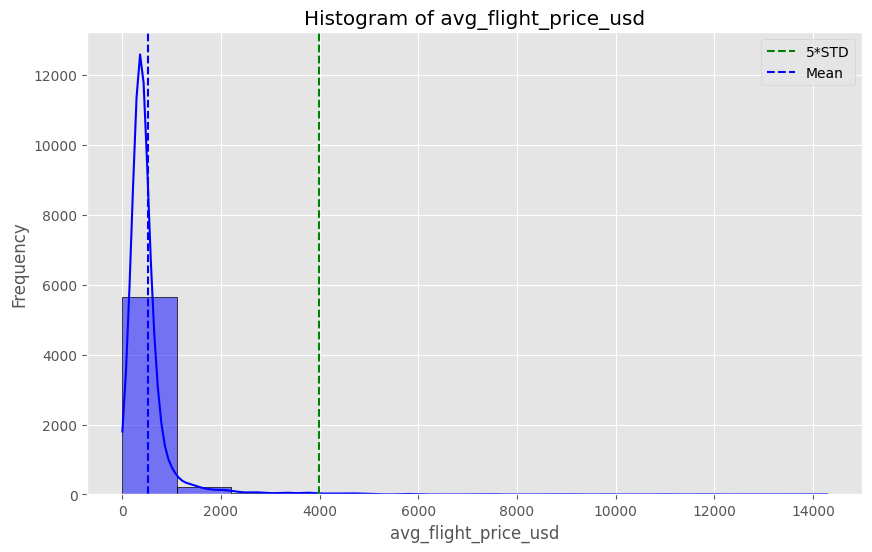

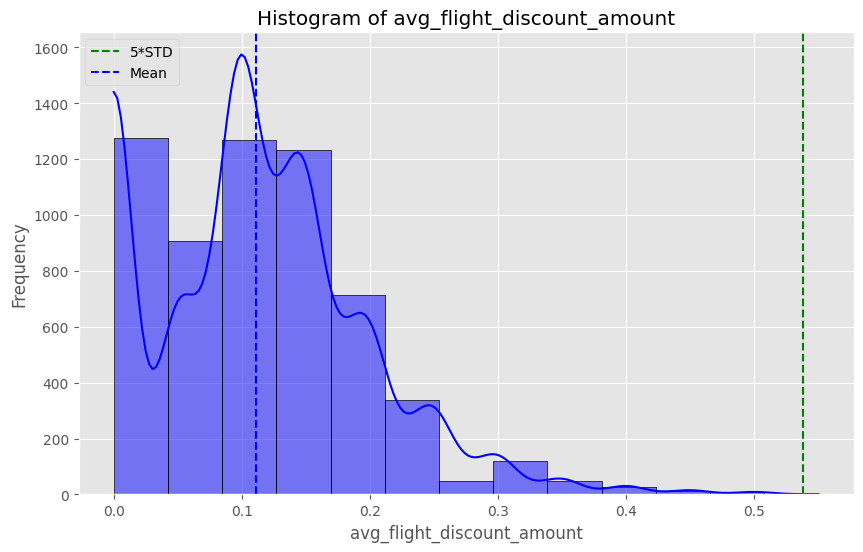

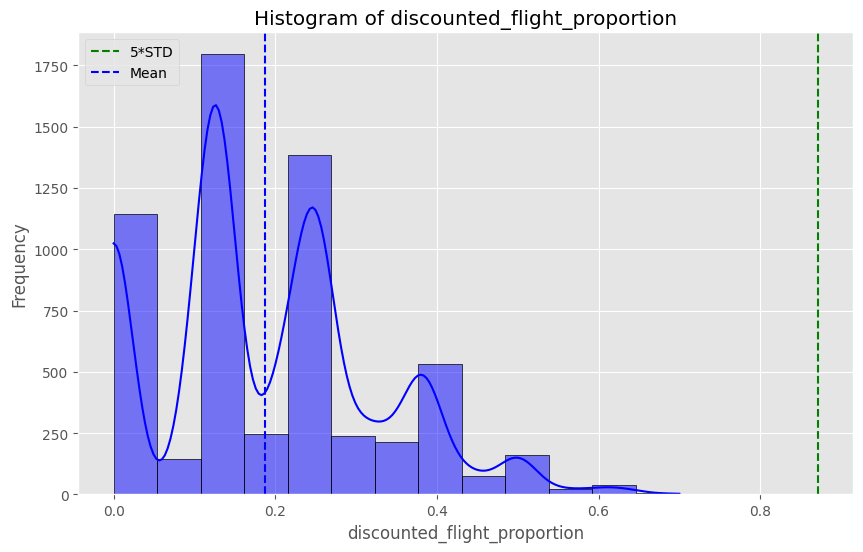

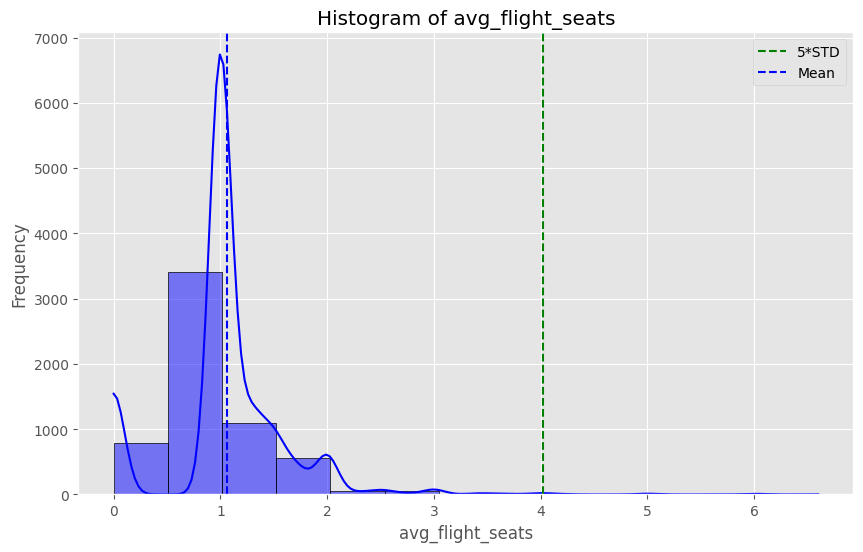

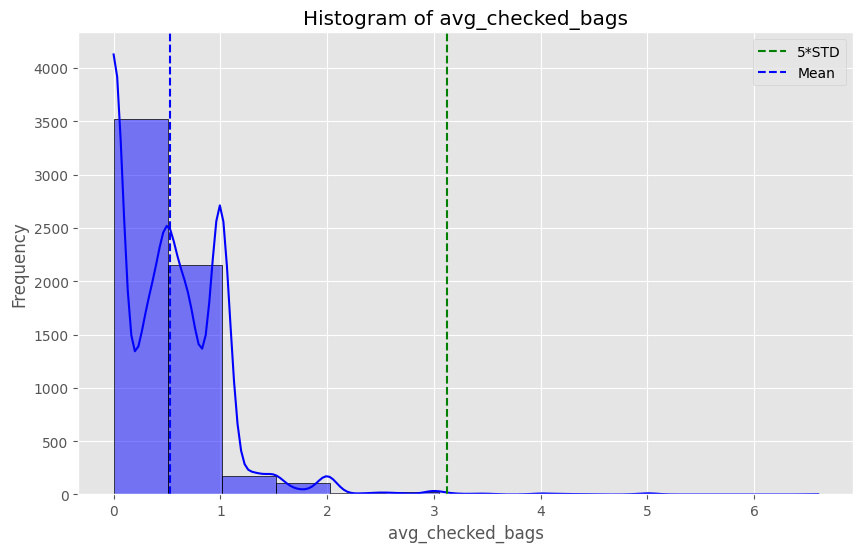

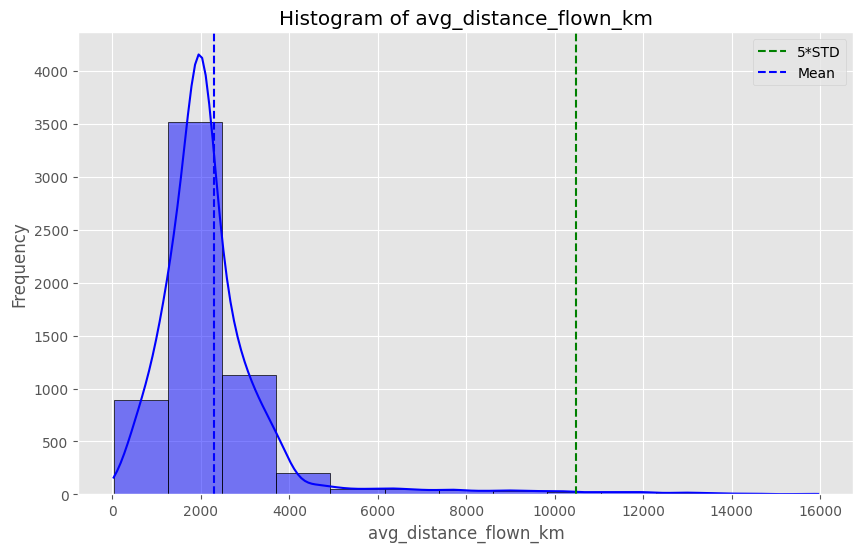

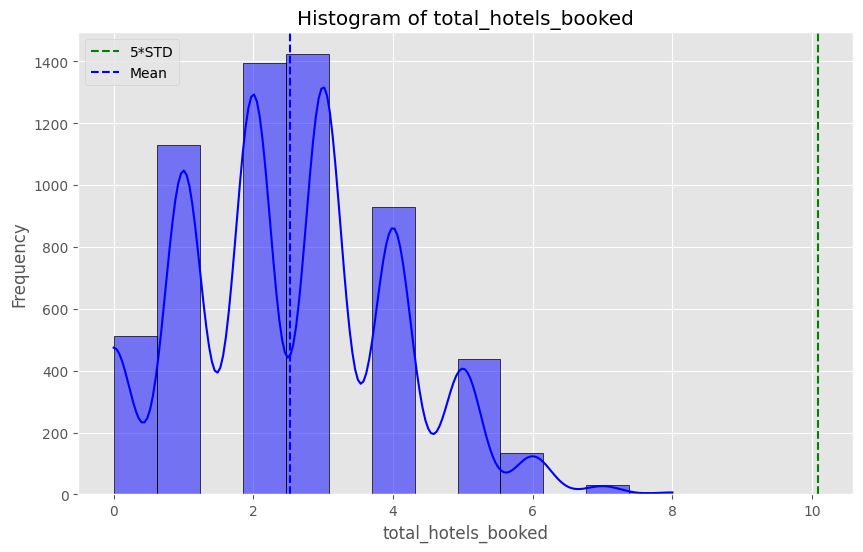

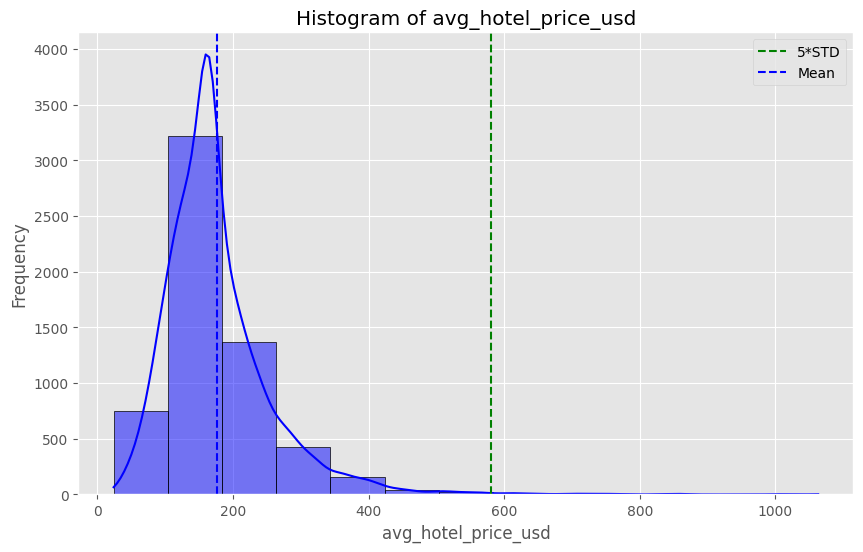

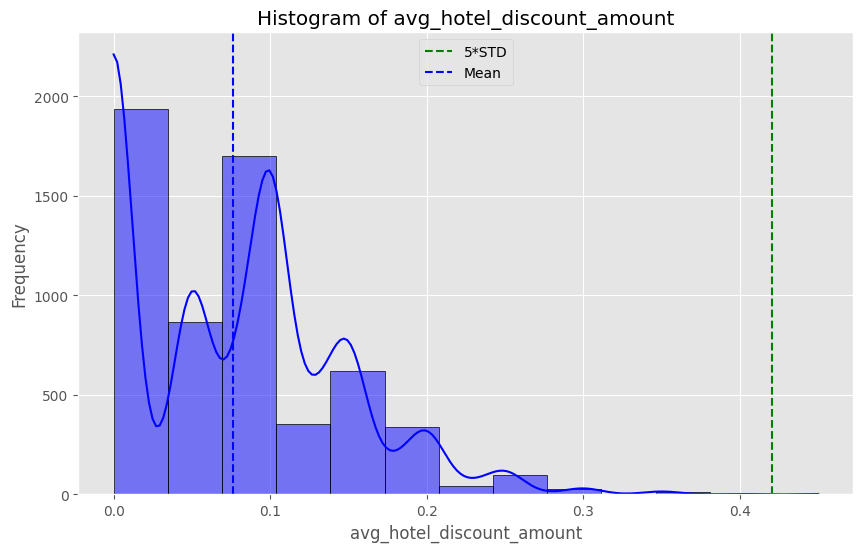

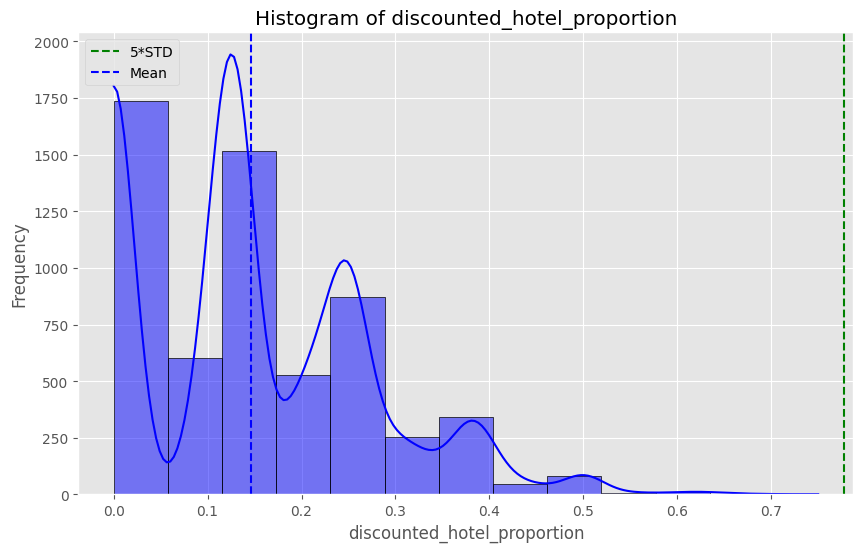

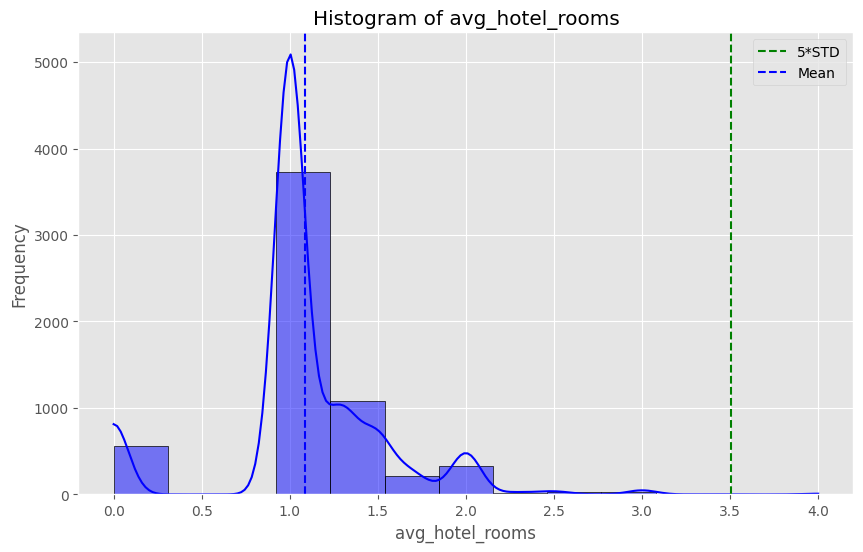

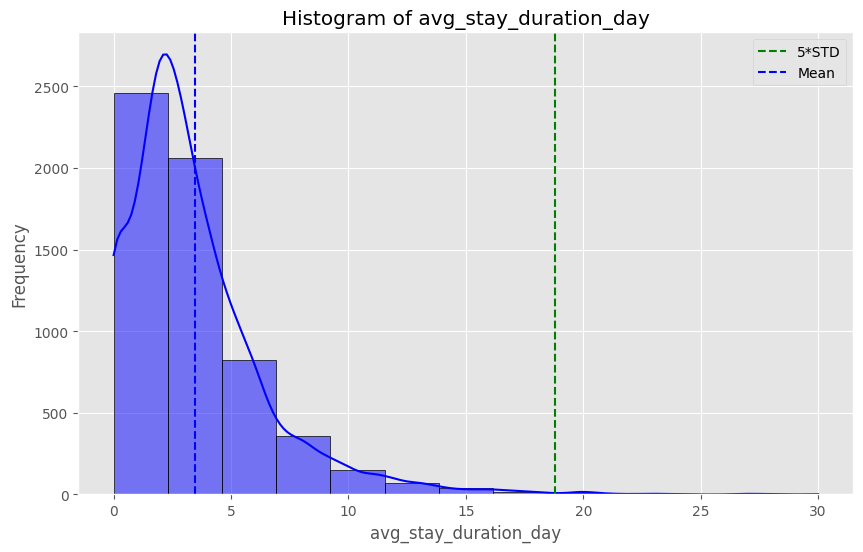

In [ ]:
# Select only numerical columns and exclude the user_id column
numerical_columns = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    bins = int(np.log2(len(cohort_users[col])) + 1)  # Sturges' formula
    upper_bound = cohort_users[col].mean() + 5 * cohort_users[col].std()
    mean = cohort_users[col].mean()

    sns.histplot(cohort_users[col], bins=bins, kde=True, edgecolor='black', color='blue')
    plt.title(f'Histogram of {col}')
    plt.axvline(upper_bound, color='g', linestyle='--', label='5*STD')  # Draw the 5*STD line on histogram
    plt.axvline(mean, color='b', linestyle='--', label='Mean')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

**Few important notes to take:**

These visualizations provided valuable insights into the distribution of the data, helping us make informed decisions for our analysis.

Using a threshold of **5*STD** is quite lenient, and values beyond this range are highly likely to be outliers.

There are multiple columns with data points beyond the 5*STD threshold.

Some columns, like avg_session_duration_minute, have a significant proportion of their data points beyond this threshold.

##Data Masking for Outlier Removal:

I utilize a masking technique to streamline our outlier filtering process:


*   I initiate a universal mask where all data points are considered valid (all set to True).
*   For each column, a column-specific mask is created based on outlier detection.
*   This column-specific mask is then combined with the universal mask to continuously refine our selection.
*   Only data points that remain True across all columns are retained, ensuring a comprehensive filtering of outliers.







This approach ensures robust outlier removal while preserving the integrity of our core data.

In [ ]:
# Select only numerical columns and exclude the user_id column
numerical_cols = [col for col in cohort_users.select_dtypes(include=['float64', 'int64']).columns if col != 'user_id']

# Initialize a mask with all True values
mask = pd.Series([True] * len(cohort_users), index=cohort_users.index)

# Create a mask to filter outliers based on 5*STD
for col in numerical_cols:
    mean_value = cohort_users[col].mean()
    std_value = cohort_users[col].std()
    lower_bound = mean_value - 5 * std_value
    upper_bound = mean_value + 5 * std_value

    # Update the mask for this column
    column_mask = (cohort_users[col] >= lower_bound) & (cohort_users[col] <= upper_bound)
    mask &= column_mask

# Reindex the mask to ensure it aligns with the DataFrame index
mask = mask.reindex(cohort_users.index)

# Filter the data using the combined mask
cohort_users = cohort_users[mask]

In [ ]:
# we had 5998 records
number_of_outliers = 5998 - cohort_users.shape[0]
percentage = round(number_of_outliers/5998 * 100,2)
print(f'{number_of_outliers} ({percentage}%) records were outliers!')

329 (5.49%) records were outliers!


## Scaling:

Before moving forward and creating new metrics, it makes sense to consider rescaling all numerical features to the same range for consistency. This way we ensure that each feature contributes equally to the computation, preventing any one feature from dominating due to its scale. We will use the **StandardScaler** method for rescaling.


However, before applying this transformation, it's crucial to note:



*   The transformed values can sometimes be harder to interpret as they no longer represent the original units or scale, this is why we keep the original columns and will add a **"scaled"** version of each to our dataset.
*   The transformed values might have a mean that is not exactly 0 and a standard deviation that is not exactly 1, as StandardScaler scales features based on mean and standard deviation.


*   The use of StandardScaler allows us to work with features that are centered around 0, which can be helpful for certain analyses. Since we've already treated outliers, this method should work well in ensuring that our features are properly scaled and ready for segmentation without being overly influenced by outliers.













In [ ]:
# List of columns to scale
cols_to_scale = ['married', 'has_children', 'age', 'session_count', 'avg_session_duration_minute', 'avg_page_clicks',
                 'total_trips', 'conversion_rate', 'weekend_trip_proportion', 'cancellation_proportion',
                 'avg_booking_departure_gap_days', 'total_flights_booked', 'round_trips_proportion',
                 'avg_flight_price_usd', 'avg_flight_discount_amount', 'discounted_flight_proportion', 'avg_flight_seats',
                 'avg_checked_bags', 'avg_distance_flown_km', 'total_hotels_booked', 'avg_hotel_price_usd',
                 'avg_hotel_discount_amount', 'discounted_hotel_proportion', 'avg_hotel_rooms', 'avg_stay_duration_day']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply scaling and create new columns with suffix "_scaled"
scaled_data = scaler.fit_transform(cohort_users[cols_to_scale])
scaled_columns = ["scaled_" + col for col in cols_to_scale]
cohort_users[scaled_columns] = scaled_data.round(2)

# check the dataset
cohort_users.head()

<ipython-input-200-da95aba91711>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_users[scaled_columns] = scaled_data.round(2)
<ipython-input-200-da95aba91711>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_users[scaled_columns] = scaled_data.round(2)
<ipython-input-200-da95aba91711>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day
0,23557,2021-07-22,65,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.95,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.95,-0.24,1.52,1.22,0.52,1.44
1,94883,2022-02-07,52,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.85,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,-0.37,-1.16,0.06,0.24,0.89,-1.03
3,101961,2022-02-17,43,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.09,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,2.94,-0.34,0.35,-0.49,-0.19,-0.08
9,149058,2022-04-14,51,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.76,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,2.28,-0.13,-1.11,0.00,0.05,1.88
10,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.42,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,-0.37,0.52,1.08,2.27,-0.19,-0.49


## Creating new metrics:

Looking at our table, let's see which fields carry information about behaviour that might be relevant to our hypothesized perks. We need to know for each perk, what kind of travel behaviour indicates affinity to the perk. We already have some metrics that will be useful for further analysis of customer segmentation and perks offering. Let's first take a look at them, and then decide what more metrics we can calculate before moving forward:

**1. Free hotel meal:**


*   Families, especially those with children, and large tour groups might prefer the convenience of a hotel meal to simplify logistics and keep meals consistent.
*   Elderly Travelers might prefer the convenience and safety of dining in the hotel rather than venturing out, especially in the evening.

Relevant Metrics: age, has_children, avg_flight_seats, avg_checked_bags, and avg_hotel_rooms

**Metric to calculate: free_meal_index**

## 1. Free hotel meal:


*   Families, especially those with children, and large tour groups might prefer the convenience of a hotel meal to simplify logistics and keep meals consistent.
*   Elderly Travelers might prefer the convenience and safety of dining in the hotel rather than venturing out, especially in the evening.

Relevant Metrics: age, has_children, avg_flight_seats, avg_checked_bags, and avg_hotel_rooms

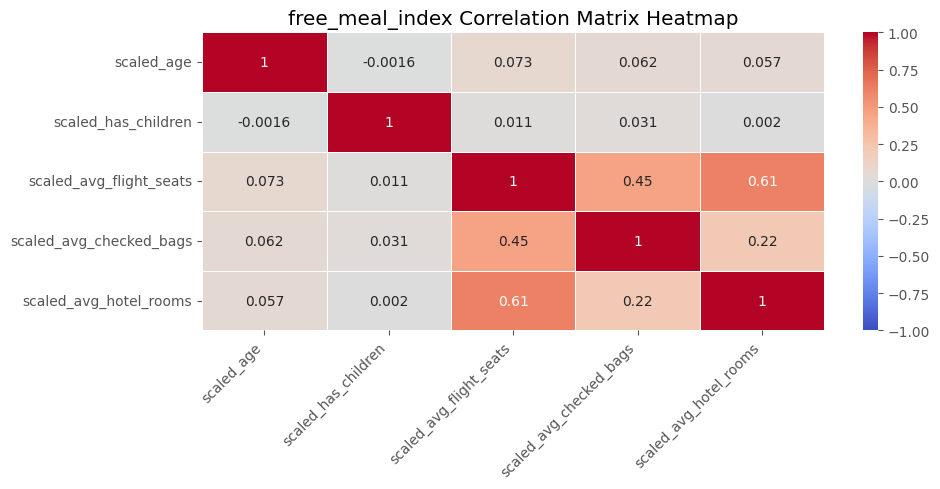

In [ ]:
# Defining the correlation_columns list
free_meal_correlation_columns = ['scaled_age', 'scaled_has_children', 'scaled_avg_flight_seats',
                                'scaled_avg_checked_bags', 'scaled_avg_hotel_rooms']

# Compute the correlation matrix for the free_meal_index
correlation_matrix = cohort_users[free_meal_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_meal_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "free_meal_index" Correlation Matrix:**

scaled_age correlation with all other metrics is low and indicates that age does not have a strong linear relationship with any of the other variables we're considering.

has_children correlation with other metrics are also very weak and indicates that while having children might be relevant from a business perspective, it doesn't have a strong linear relationship with other variables. However, its binary nature might impact its correlation magnitude with other scaled metrics.

scaled_avg_flight_seats has a moderate correlation with scaled_avg_checked_bags and a strong correlation with scaled_avg_hotel_rooms. This suggests that the more flight seats a user books, the more likely they are to also book more hotel rooms and have more checked bags. This might indicate group or family travel.

scaled_avg_checked_bags and scaled_avg_hotel_rooms have weak to moderate relationship. This indicates some relationship between the number of checked bags and the number of hotel rooms, but not as strong as one might expect.

**Calculate the free_meal_index:**

As we already saw, scaled_avg_flight_seats and scaled_avg_hotel_rooms has a strong correlation, so I'll drop scaled_avg_hotel_rooms to not include the same information. Normally unless we have strong reasons we’d probably use a uniform scaling, in this case 0.25 for each.

In [ ]:
# Define the weights for each feature
weights = {
    'scaled_age': 0.25,
    'scaled_has_children': 0.25,
    'scaled_avg_flight_seats': 0.25,
    'scaled_avg_checked_bags': 0.25
}

# Initialize the free_meal_index column to 0
cohort_users['free_meal_index'] = 0

# Calculate the free_meal_index using the weighted average
for column, weight in weights.items():
    cohort_users['free_meal_index'] += cohort_users[column] * weight

## 2. Free checked bags:

*   Long-Term Travelers tend to have more luggage.

*   Travelers covering long distances often stay at their destinations for extended periods, requiring them to pack more items for a variety of situations and potentially different climates. They might carry gifts/souvenirs with them.

*   Families might have extra luggage, especially when travelling with children (strollers, toys, etc.).

*   Travelers Booking Round Trips usually prefer for convenience and predictability. Having a free checked bag aligns with this mindset, offering a hassle-free experience by eliminating potential additional costs or decisions about luggage on both legs of their journey.

**Relevant Metrics:** avg_stay_duration_day, avg_distance_flown_km, has_children, avg_checked_bags, and round_trips_proportion

**Metric to calculate: free_bag_index**

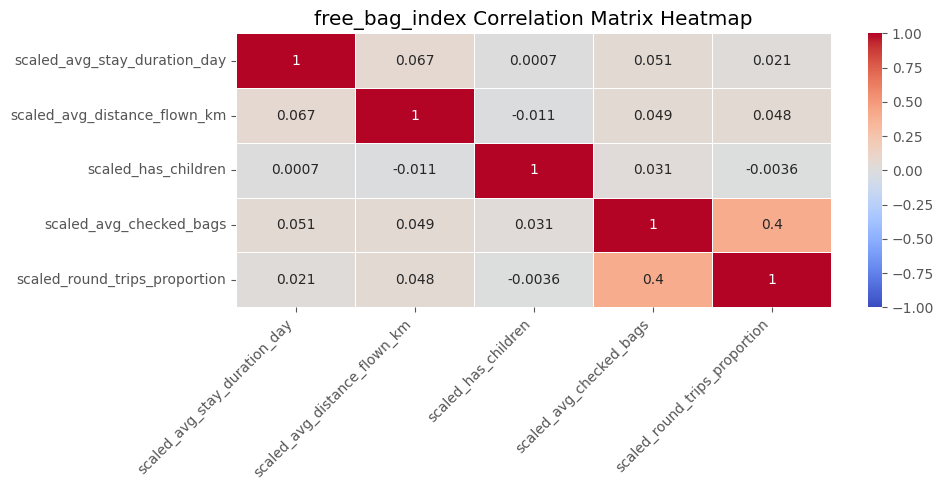

In [ ]:
# Defining the correlation_columns list
free_bag_correlation_columns = ['scaled_avg_stay_duration_day', 'scaled_avg_distance_flown_km',
                                'scaled_has_children', 'scaled_avg_checked_bags', 'scaled_round_trips_proportion']


# Compute the correlation matrix for the free_bag_index
correlation_matrix = cohort_users[free_bag_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("free_bag_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "free_bag_index" Correlation Matrix:**
The correlation between scaled_avg_checked_bag and round_trip_proportion stands out as the strongest and is meaningful from a business perspective.

Most of the other correlations are **weak**, but given the business context, they might still be significant for the index. Even with weak correlations, has_children might be an essential metric due to its business significance.

A **weighted average** can be a good method to calculate the index. As we don't have a strong correlation between metrics, I'll use a uniform scaling, 0.20 for each.

In [ ]:
# Define the weights for each feature
weights = {
    'scaled_avg_stay_duration_day': 0.20,
    'scaled_avg_distance_flown_km': 0.20,
    'scaled_has_children': 0.20,
    'scaled_avg_checked_bags': 0.20,
    'scaled_round_trips_proportion': 0.20
}


# Calculate the free_bag_index using the weighted average
cohort_users['free_bag_index'] = 0  # initialize the index column to 0

for column, weight in weights.items():
    cohort_users['free_bag_index'] += cohort_users[column] * weight

## 3. No cancellation fees:

*   Uncertain Travelers who aren’t sure about their plans or are booking well in advance might value this perk.
*   Travelers with a High Number of Cancelled Trips are likely value flexibility in future bookings to avoid incurring costs.

**Relevant Metrics:** avg_booking_departure_gap_days and cancellations_proportion

**Metric to calculate: last_min_booker_index**

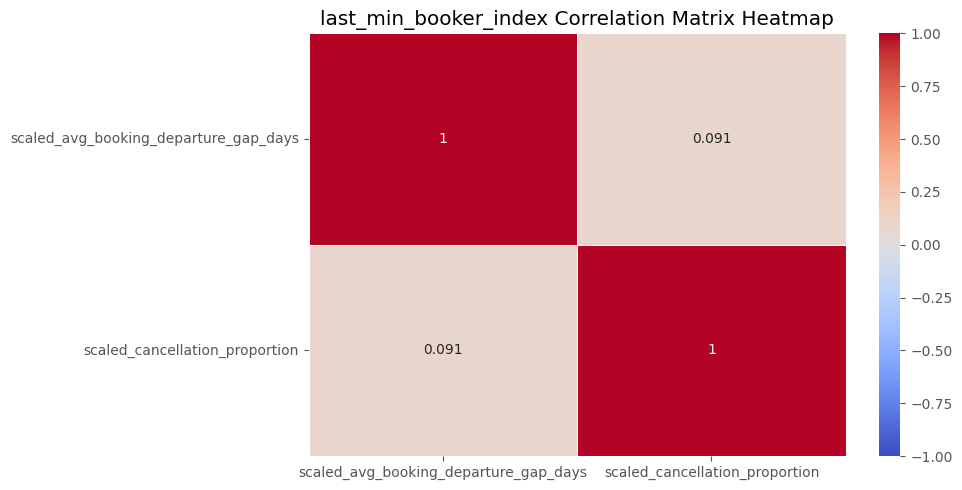

In [ ]:
# Defining the correlation_columns list
last_min_correlation_columns = ['scaled_avg_booking_departure_gap_days', 'scaled_cancellation_proportion']

# Compute the correlation matrix for the last_min_booker_index
scaled_correlation_matrix = cohort_users[last_min_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Set the title and show the plot
plt.title("last_min_booker_index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "last_min_booker_index" Correlation Matrix:**

The **correlation coefficient** of **0.091** between the two metrics suggests a **very weak positive** linear relationship, which means that the two metrics are capturing somewhat different aspects of the behavior, which is good for differentiation. If they were highly correlated, they'd be redundant.

Our analysis indicates two primary user behavior types:

*   **Planning in Advance:** Users with longer average booking departure gaps tend to plan their trips well in advance. This may indicate they are less likely to cancel bookings due to more concrete travel plans.
*   **Low Cancellation Propensity:** Users with lower cancellation proportions are less likely to cancel bookings, suggesting a stronger commitment to travel plans.

Since both columns are already scaled, we can directly use them in our index calculation using weighted average method.

In [ ]:
# Define weights
w1 = 0.5  # Weight for scaled_cancellation_proportion
w2 = 0.5  # Weight for scaled_avg_booking_departure_gap_days

'''
Subtracting the scaled_avg_booking_departure_gap_days from max_value will ensure that
lower values (indicating last-minute booking) contribute more to the index.
'''
# Calculate the last_min_booker_index using the weighted average
max_gap = cohort_users['scaled_avg_booking_departure_gap_days'].max()

cohort_users['last_min_booker_index'] = w1 * cohort_users['scaled_cancellation_proportion'] + w2 * (max_gap - cohort_users['scaled_avg_booking_departure_gap_days'])

## 4. Exclusive discounts:

This one is a bit unclear compared to the other perks. Based on what the Marketing Manager said, we're looking for **price-sensitive customers.**

**Relevant Metrics:**

conversion_rate: A low conversion rate, indicating unwillingness to buy except at a low enough price avg_session_duration_minute and avg_page_clicks: Longer values might indicate bargain-hunting behaviour avg_flight_discount_amount, discounted_flight_proportion, avg_hotel_discount_amount and discounted_hotel_proportion

**Metric to calculate: bargain_hunter_index**

But first we will calculate another metric, average_dollar_saved_per_km

In [ ]:
# Caluculating the average_dollar_saved_per_kilometre metric
avg_usd_saved_per_km = round(cohort_users['avg_flight_discount_amount']
                                                    * cohort_users['avg_flight_price_usd']
                                                    / cohort_users['avg_distance_flown_km'],2)

# Determine the position to insert the new column after the last_min_booking columns
position = cohort_users.columns.get_loc('avg_distance_flown_km') + 1

# Insert the new column which is the maximum of the both columns at the desired position
cohort_users.insert(position, 'avg_usd_saved_per_km', avg_usd_saved_per_km)

# Initialize the StandardScaler to scale the new metric
scaler = StandardScaler()

# Reshape the data to a 2D array-like structure as StandardScaler expects
# Each row corresponds to a sample and each column corresponds to a feature
scaled_data = avg_usd_saved_per_km.values.reshape(-1, 1)

# Apply scaling and create a new column with suffix "_scaled"
scaled_data = scaler.fit_transform(scaled_data)
cohort_users['scaled_avg_usd_saved_per_km'] = scaled_data.round(2)

# Determine the position to insert the new scaled column after the scaled_avg_stay_duration_day column
# It's just a personal preference as I want to have all the scaled columns next to each other
scaled_position = cohort_users.columns.get_loc('scaled_avg_stay_duration_day') + 1

# Insert the new scaled column after the scaled_avg_stay_duration_day column
cohort_users.insert(scaled_position, 'scaled_avg_usd_saved_per_km', cohort_users.pop('scaled_avg_usd_saved_per_km'))

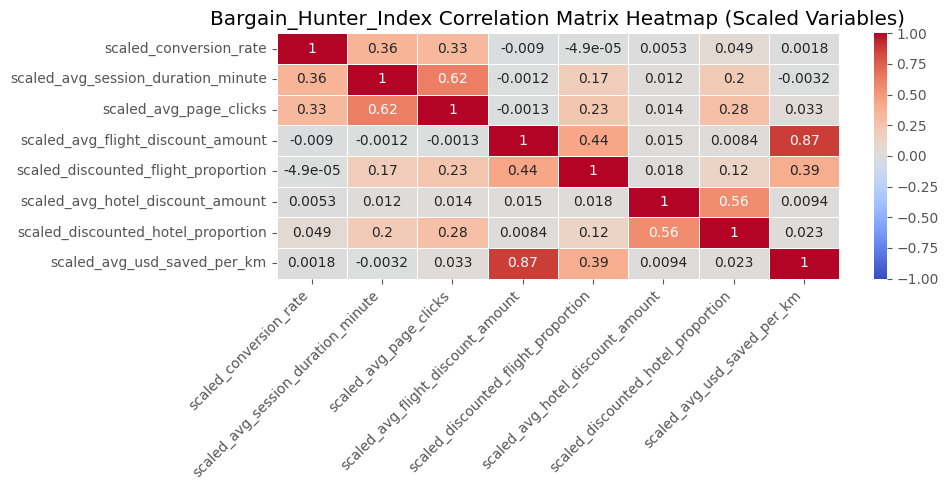

In [ ]:
# Defining the correlation_columns list
bargain_correlation_columns = [
    'scaled_conversion_rate',
    'scaled_avg_session_duration_minute',
    'scaled_avg_page_clicks',
    'scaled_avg_flight_discount_amount',
    'scaled_discounted_flight_proportion',
    'scaled_avg_hotel_discount_amount',
    'scaled_discounted_hotel_proportion',
    'scaled_avg_usd_saved_per_km'
]

# Compute the correlation matrix for the bargain_hunter_index relevant metrics using the scaled columns
scaled_correlation_matrix = cohort_users[bargain_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(scaled_correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Bargain_Hunter_Index Correlation Matrix Heatmap (Scaled Variables)")
plt.tight_layout()
plt.show()

**Observations from the Correlation Matrix:**
scaled_conversation_rate has **moderate positive** correlations with scaled_avg_session_duration_minute and scaled_avg_page_clicks. This indicates that customers who spend more time on the platform and click on more pages tend to convert less frequently, which is consistent with them being more price-sensitive. The correlations between scaled_conversion_rate and the rest of features are all **very weak**, suggesting that these direct price-related features may not individually explain conversion behavior well.

There's a strong correlation between scaled_avg_session_duration_minute and scaled_avg_page_clicks, implying users who spend more time on the site tend to click on more pages.

Among all the price-related features, the strongest correlation is between scaled_avg_flight_discount_amount and scaled_avg_usd_saved_per_km. This indicates that the customers who tend to get higher flight discounts also tend to save more per kilometer, not a surprise as the avg_usd_saved is the product of scaled_avg_flight_discount_amount. So I will remove avg_flight_discount_amount from the index calculation.

scaled_avg_page_clicks has **moderate positive** correlations with scaled_discounted_flight_proportion and scaled_discounted_hotel_proportion. This suggests that customers clicking more pages may be actively searching for discounts.

The **bargain_hunting_index** can be represented as a **weighted average** of the given metrics. Due to a strong correlatin between scaled_avg_flight_discount_amount and scaled_avg_usd_saved_per_km, I'll drop the first one (as the second one is the product of the first one). Also I'll drop scaled_aveg_hotel_disount_amount and only keep scaled_discounted_hotel_proportion, and will drop scaled_avg_session_duration_minute and will keep scaled_avg_page_clicks.



In [ ]:
# Calculate the bargain_hunter_index using the weighted average
# Define the weights for each feature
weights = {
    'scaled_conversion_rate': 0.2,
    'scaled_avg_page_clicks': 0.2,
    'scaled_discounted_flight_proportion': 0.2,
    'scaled_discounted_hotel_proportion': 0.2,
    'scaled_avg_usd_saved_per_km': 0.2
}

# Calculate the bargain_hunting_index for each row
cohort_users['bargain_hunting_index'] = 0

for column, weight in weights.items():
    value = (1 - cohort_users[column]) if column == 'conversion_rate' else cohort_users[column]
    cohort_users['bargain_hunting_index'] += weight * value

## 5. 1-night free hotel with a flight:




*   **Frequent Flyers**, especially those who often book **round trips**, would appreciate the added value of a free hotel night.
*   **Short-Stay Travelers** or **Weekend Getaway Travelers** who typically book short stays might find this perk particularly enticing as it significantly reduces their accommodation cost.

**Relevant Metrics:** total_flights_booked, weekend_trip_proportion, round_trips_proportion, total_hotels_booked

**Metric to calculate: free_hotel_index**



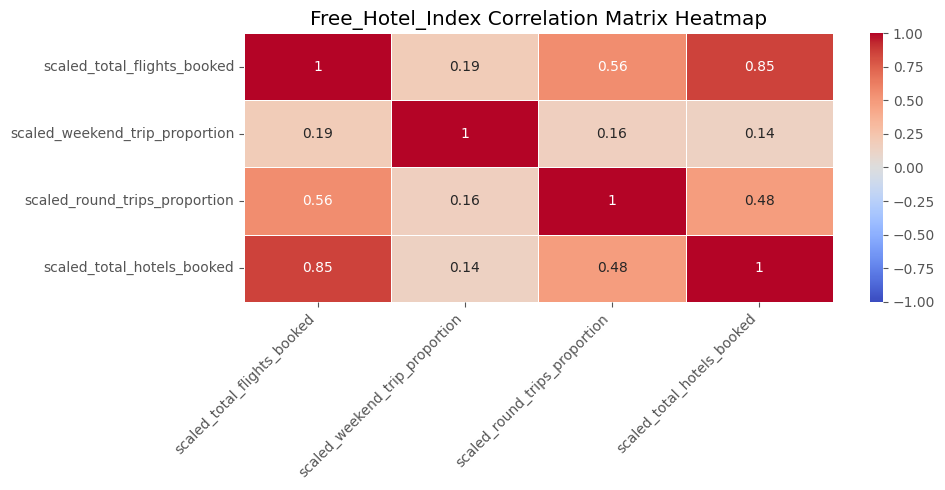

In [ ]:
# Defining the correlation_columns list
hotel_correlation_columns = [
    'scaled_total_flights_booked',
    'scaled_weekend_trip_proportion',
    'scaled_round_trips_proportion',
    'scaled_total_hotels_booked'
]

# Compute the correlation matrix for the fee_hotel_index
correlation_matrix = cohort_users[hotel_correlation_columns].corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 5))

# Generate a heatmap for the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)

# Adjust the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title and show the plot
plt.title("Free_Hotel_Index Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

**Observations from the "free_hotel_index" Correlation Matrix:**

scaled_total_flights_booked has a **strong** correlation with scaled_total_hotels_booked, which makes sense — frequent flyers are likely to book hotels often. It also has a moderate correlation with scaled_round_trips_proportion, implying frequent flyers often book round trips.

scaled_weekend_trip_proportion shows **weak** correlation with the other metrics.

scaled_round_trips_proportion has a **moderate** correlation with scaled_total_flights_booked and scaled_total_hotels_booked suggests that travelers booking round trips also often book flights and hotels together.



*   The strong correlation between scaled_total_flights_booked and scaled_total_hotels_booked indicates that frequent flyers often book hotels. This connection is a critical insight for the 1-night free hotel with a flight" perk.
*   The moderate correlations involving scaled_round_trips_proportion indicate the relevance of round trip bookings in the context of this perk.

I will use weighted average to calculate this metric. Same as before, I'll drop scaled_total_flights_booked and scaled_round_trips_proportion.

In [ ]:
# Calculate the free_hotel_index using the weighted average
# Define the weights for each feature
weights = {
    'scaled_weekend_trip_proportion': 0.50,
    'scaled_total_hotels_booked': 0.50
}


# Initialize the free_hotel_index column to 0
cohort_users['free_hotel_index'] = 0

# Calculate the free_hotel_index for each row
for column, weight in weights.items():
    cohort_users['free_hotel_index'] += cohort_users[column] * weight

# Verify the creation of all the indexes
cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,avg_usd_saved_per_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,scaled_avg_usd_saved_per_km,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index
0,23557,2021-07-22,65,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,0.03,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.95,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.95,-0.24,1.52,1.22,0.52,1.44,0.31,0.5750,0.560,1.890,0.330,0.285
1,94883,2022-02-07,52,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,0.04,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.85,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,-0.37,-1.16,0.06,0.24,0.89,-1.03,0.79,0.6225,0.478,1.410,-0.224,-0.375
3,101961,2022-02-17,43,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,0.02,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.09,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,2.94,-0.34,0.35,-0.49,-0.19,-0.08,-0.17,-0.1650,-0.124,1.680,0.234,1.880
9,149058,2022-04-14,51,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,0.01,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.76,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,2.28,-0.13,-1.11,0.00,0.05,1.88,-0.65,0.8975,0.866,2.390,0.036,0.950
10,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,0.06,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.42,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,-0.37,0.52,1.08,2.27,-0.19,-0.49,1.76,0.4750,1.570,3.645,0.824,-0.375


## Segmenting customers by Fuzzy Segmentation:

In [ ]:
# Select only indexes columns
indexes_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index',
                   'bargain_hunting_index', 'free_hotel_index']

indexes = cohort_users[indexes_columns]
indexes.head()

,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index
0,0.5750,0.560,1.890,0.330,0.285
1,0.6225,0.478,1.410,-0.224,-0.375
3,-0.1650,-0.124,1.680,0.234,1.880
9,0.8975,0.866,2.390,0.036,0.950
10,0.4750,1.570,3.645,0.824,-0.375


In [ ]:
indexes.describe().T

,count,mean,std,min,25%,50%,75%,max
free_meal_index,5669.0,-0.000276,0.572930,-1.470,-0.315,-0.005,0.3625,3.3725
free_bag_index,5669.0,0.000901,0.502839,-1.276,-0.278,-0.012,0.2900,2.5560
last_min_booker_index,5669.0,1.629603,0.674494,-0.130,1.670,1.680,1.6850,4.5550
bargain_hunting_index,5669.0,-0.000023,0.563220,-1.352,-0.384,-0.044,0.3020,3.2920
free_hotel_index,5669.0,-0.001462,0.756261,-1.040,-0.710,-0.045,0.2850,2.8500


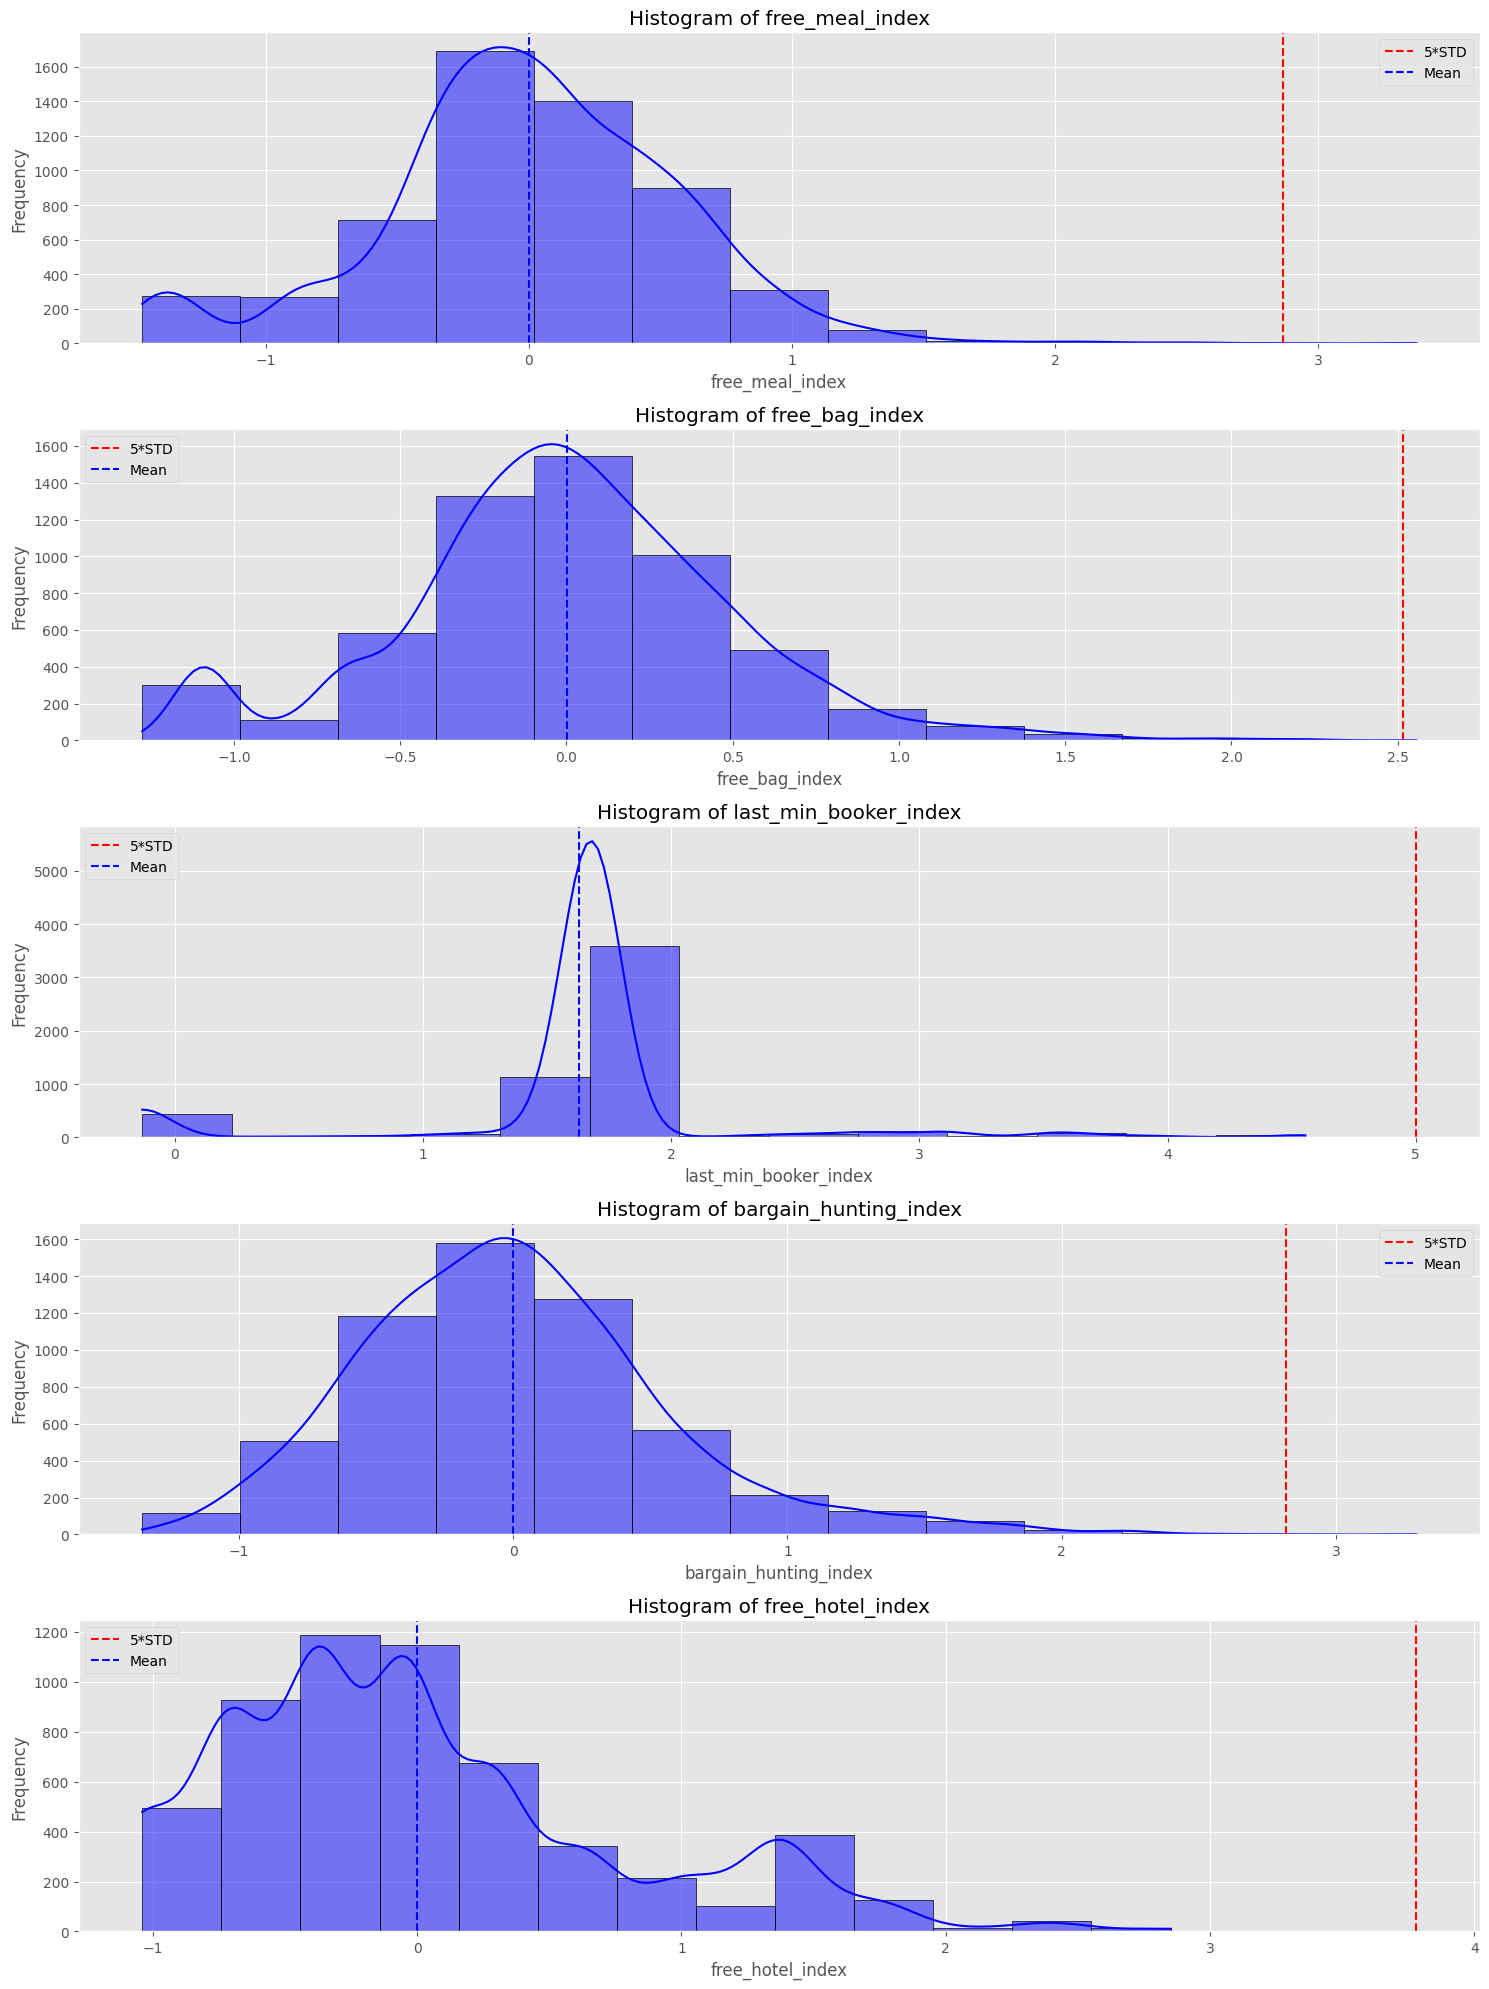

In [ ]:
# Set up the figure
fig, axes = plt.subplots(len(indexes_columns), 1, figsize=(15, 4 * len(indexes_columns)))

for i, col in enumerate(indexes_columns):
    # Compute the outlier bounds
    upper_bound = cohort_users[col].mean() + 5 * cohort_users[col].std()
    mean = cohort_users[col].mean()

    # Plot histogram
    bins = int(np.log2(len(indexes[col])) + 1)  # Sturges' formula
    sns.histplot(indexes[col], ax=axes[i], bins=bins, kde=True, edgecolor='black', color='blue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].axvline(upper_bound, color='r', linestyle='--', label=f'5*STD')
    axes[i].axvline(mean, color='b', linestyle='--', label='Mean')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Ranking Perk Indexes

For each perk, we'll perform the following tasks:

*   Sort the dataset by the respective perk index in descending order.
*   Assign ranks starting from 1 to N, where N is the total number of customers.

In [ ]:
# Initialize an empty DataFrame to store the ranks, setting user_id as the index for easier alignment
rank_df = pd.DataFrame()
rank_df['user_id'] = cohort_users['user_id']
rank_df.set_index('user_id', inplace=True)

# List of perk indexes
perk_indexes = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Loop through each perk index to sort and rank
for perk in perk_indexes:
    # Sort by the perk index and reset the index
    sorted_data = cohort_users.sort_values(by=[perk], ascending=False).reset_index(drop=True)

    # Assign rank starting from 1 to N
    sorted_data[f'{perk}_rank'] = sorted_data.index + 1

    # Align the ranks with the original user_id and store them in the rank DataFrame
    rank_df[f'{perk}_rank'] = sorted_data.set_index('user_id')[f'{perk}_rank']

# Reset the index for the final DataFrame
rank_df.reset_index(inplace=True)

# Display the first few rows of the rank DataFrame
rank_df.head()


,user_id,free_meal_index_rank,free_bag_index_rank,last_min_booker_index_rank,bargain_hunting_index_rank,free_hotel_index_rank
0,23557,824,632,404,1327,1629
1,94883,698,837,5091,3630,3708
2,101961,3570,3476,2330,1656,69
3,149058,269,232,378,2491,869
4,152583,1089,29,82,426,4044


**Ranking Perk Indexes**

For each customer, we now have the following rank columns:

**free_meal_index_rank**

**free_bag_index_rank**

**last_min_booker_index_rank**

**bargain_hunting_index_rank**

**free_hotel_index_rank**

The rank starts from 1, indicating the highest affinity for a particular perk, and goes up to N, where N is the total number of customers.

**Find Minimum Rank Perk for Each Customer**

The next step is to find out which perk has the minimum rank for each customer. The perk with the lowest rank will be the one that the customer most belongs to. Let's proceed with this step.

In [ ]:
# Calculate the minimum rank for each customer and the corresponding perk index
rank_df['min_rank'] = rank_df.iloc[:, 1:].min(axis=1)
rank_df['best_index'] = rank_df.iloc[:, 1:].idxmin(axis=1).str.replace('_rank', '')

# Display the first few rows of the rank DataFrame with the min rank and best perk
rank_df.head()

,user_id,free_meal_index_rank,free_bag_index_rank,last_min_booker_index_rank,bargain_hunting_index_rank,free_hotel_index_rank,min_rank,best_index
0,23557,824,632,404,1327,1629,404,last_min_booker_index
1,94883,698,837,5091,3630,3708,698,free_meal_index
2,101961,3570,3476,2330,1656,69,69,free_hotel_index
3,149058,269,232,378,2491,869,232,free_bag_index
4,152583,1089,29,82,426,4044,29,free_bag_index


**Finding the Minimum Rank Perk**

We have successfully identified the perk with the minimum rank for each customer. Two new columns have been added to the rank_df DataFrame:


*   min_rank: Indicates the minimum rank among all the perks for each customer.
*   best_index: Indicates the perk corresponding to the minimum rank.


This means the perk listed in **best_perk** is the one to which the customer most belongs, as per the fuzzy segmentation.

## Summarize the Segmentation

To finalize, let's summarize the segmentation by counting how many customers are most inclined toward each perk. This will give us an idea of the distribution of perks among customers.

In [ ]:
# Count the number of customers most inclined towards each perk
perk_distribution = rank_df['best_index'].value_counts().reset_index()
perk_distribution.columns = ['Best Index', 'Number of Customers']

# Create a dictionary to map the index names to the perk names
perk_names = {
    'free_meal_index': 'Free hotel meal',
    'free_bag_index': 'Free checked bag',
    'last_min_booker_index': 'No cancellation fees',
    'bargain_hunting_index': 'Exclusive discounts',
    'free_hotel_index': '1-night free hotel with a flight'
}

# Add a new column for the perk names
perk_distribution['Perk Name'] = perk_distribution['Best Index'].map(perk_names)

# Reorder columns for better readability
perk_distribution = perk_distribution[['Best Index', 'Perk Name', 'Number of Customers']]

# Display the updated distribution with perk names
perk_distribution

,Best Index,Perk Name,Number of Customers
0,bargain_hunting_index,Exclusive discounts,1276
1,free_hotel_index,1-night free hotel with a flight,1246
2,last_min_booker_index,No cancellation fees,1152
3,free_meal_index,Free hotel meal,1059
4,free_bag_index,Free checked bag,936


In [ ]:
# Map the index names to the more descriptive perk names for segment labels
rank_df['segment_label'] = rank_df['best_index'].map(perk_names)

# Drop the 'best_index' column as we now have 'segment_label'
rank_df.drop(columns=['best_index'], inplace=True)

# Perform the join based on user_id
cohort_users = cohort_users.merge(rank_df[['user_id', 'segment_label']], on='user_id', how='left')

cohort_users.head()

,user_id,sign_up_date,age,gender,married,has_children,home_country,home_city,session_count,avg_session_duration_minute,avg_page_clicks,total_trips,conversion_rate,weekend_trip_proportion,cancellation_proportion,avg_booking_departure_gap_days,total_flights_booked,round_trips_proportion,avg_flight_price_usd,avg_flight_discount_amount,discounted_flight_proportion,avg_flight_seats,avg_checked_bags,avg_distance_flown_km,avg_usd_saved_per_km,total_hotels_booked,avg_hotel_price_usd,avg_hotel_discount_amount,discounted_hotel_proportion,avg_hotel_rooms,avg_stay_duration_day,has_booked,has_booked_flight,has_booked_hotel,scaled_married,scaled_has_children,scaled_age,scaled_session_count,scaled_avg_session_duration_minute,scaled_avg_page_clicks,scaled_total_trips,scaled_conversion_rate,scaled_weekend_trip_proportion,scaled_cancellation_proportion,scaled_avg_booking_departure_gap_days,scaled_total_flights_booked,scaled_round_trips_proportion,scaled_avg_flight_price_usd,scaled_avg_flight_discount_amount,scaled_discounted_flight_proportion,scaled_avg_flight_seats,scaled_avg_checked_bags,scaled_avg_distance_flown_km,scaled_total_hotels_booked,scaled_avg_hotel_price_usd,scaled_avg_hotel_discount_amount,scaled_discounted_hotel_proportion,scaled_avg_hotel_rooms,scaled_avg_stay_duration_day,scaled_avg_usd_saved_per_km,free_meal_index,free_bag_index,last_min_booker_index,bargain_hunting_index,free_hotel_index,segment_label
0,23557,2021-07-22,65,F,True,False,usa,new york,12,6.93,17.50,4,0.33,0.00,0.25,248.05,2,1.0,518.29,0.15,0.21,1.00,1.00,2680.73,0.03,4,157.33,0.18,0.29,1.33,7.33,True,True,True,1.13,-0.69,1.95,4.81,4.98,-0.04,0.73,-0.05,-0.38,2.59,2.07,-0.27,0.5,0.15,0.46,0.21,-0.06,1.10,0.45,0.95,-0.24,1.52,1.22,0.52,1.44,0.31,0.5750,0.560,1.890,0.330,0.285,No cancellation fees
1,94883,2022-02-07,52,F,True,False,usa,kansas city,12,0.50,8.33,3,0.25,0.00,0.00,60.98,3,1.0,1784.95,0.10,0.08,1.67,1.00,5057.35,0.04,2,90.00,0.08,0.17,1.50,0.50,True,True,True,1.13,-0.69,0.85,4.81,-1.06,-0.92,0.10,-0.48,-0.38,-0.26,0.18,0.36,0.5,3.62,-0.13,-0.75,1.23,1.10,2.51,-0.37,-1.16,0.06,0.24,0.89,-1.03,0.79,0.6225,0.478,1.410,-0.224,-0.375,Free hotel meal
2,101961,2022-02-17,43,F,True,False,usa,boston,12,2.00,18.17,7,0.58,0.14,0.00,7.34,6,1.0,321.53,0.13,0.25,1.00,0.50,1753.36,0.02,7,150.29,0.10,0.08,1.00,3.14,True,True,True,1.13,-0.69,0.09,4.81,0.35,0.03,2.61,1.29,0.82,-0.26,-0.36,2.26,0.5,-0.39,0.22,0.51,-0.06,-0.00,-0.35,2.94,-0.34,0.35,-0.49,-0.19,-0.08,-0.17,-0.1650,-0.124,1.680,0.234,1.880,1-night free hotel with a flight
3,149058,2022-04-14,51,F,False,True,usa,birmingham,12,2.79,15.36,6,0.50,0.00,0.17,58.79,6,1.0,664.40,0.05,0.21,1.56,0.67,2304.81,0.01,6,165.67,0.00,0.14,1.11,8.56,True,True,True,-0.89,1.45,0.76,4.81,1.09,-0.24,1.99,0.86,-0.38,1.68,0.16,2.26,0.5,0.55,-0.72,0.21,1.01,0.37,0.13,2.28,-0.13,-1.11,0.00,0.05,1.88,-0.65,0.8975,0.866,2.390,0.036,0.950,Free checked bag
4,152583,2022-04-17,37,F,False,False,usa,colorado springs,10,6.17,21.25,2,0.20,0.00,0.50,181.16,2,1.0,3769.43,0.15,0.25,1.80,1.20,10253.52,0.06,2,213.00,0.15,0.42,1.00,2.00,True,True,True,-0.89,-0.69,-0.42,2.13,4.27,0.33,-0.53,-0.75,-0.38,5.43,1.40,-0.27,0.5,9.06,0.46,0.51,1.47,1.54,6.99,-0.37,0.52,1.08,2.27,-0.19,-0.49,1.76,0.4750,1.570,3.645,0.824,-0.375,Free checked bag


To get a better understanding of each of the clusters, we can plot their distribution in regards to each of the chosen variables to make sure our cluster averages are not defined by large outliers (this is a check to make sure our k-means clusters are robust).

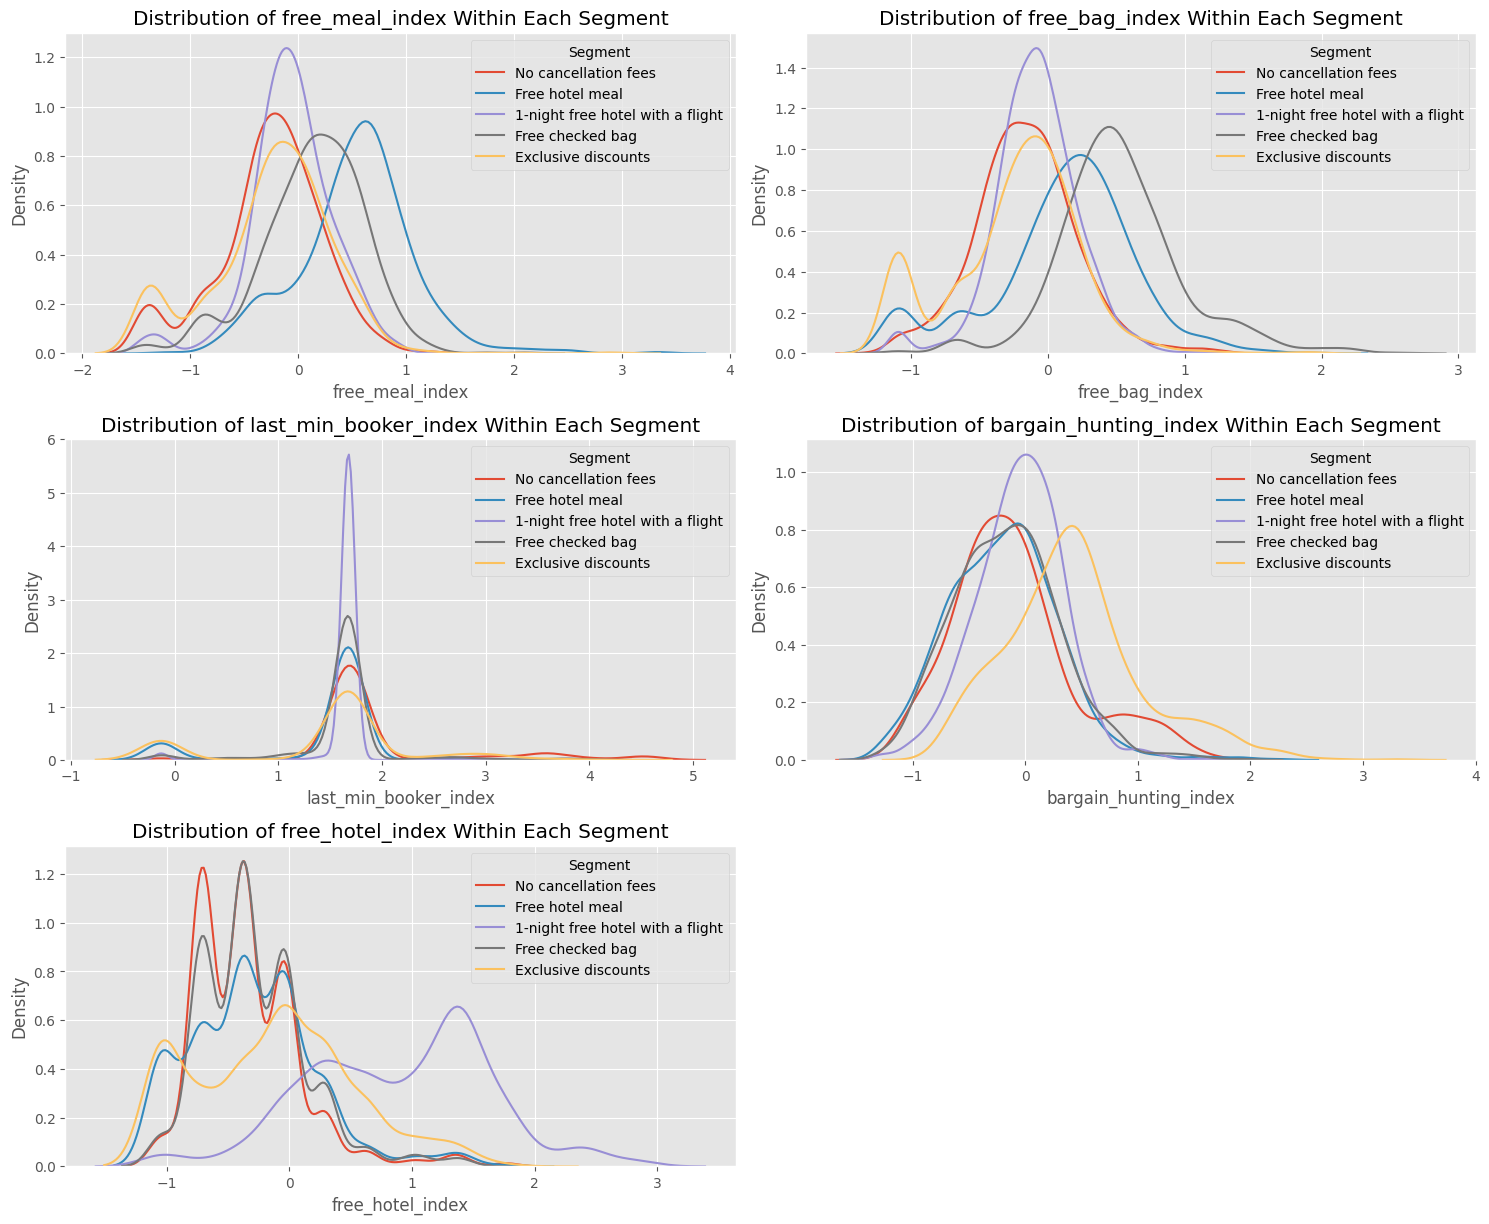

In [ ]:
# Filtering only the columns that contain the indexes
index_columns = ['free_meal_index', 'free_bag_index', 'last_min_booker_index', 'bargain_hunting_index', 'free_hotel_index']

# Extract unique segment labels from the 'segment_labels' column
segments = cohort_users['segment_label'].unique()

# Calculate the number of rows and columns for the subplot grid
n_rows = len(index_columns)  # One row per feature
n_cols = 2  # Two columns per row

# Create subplots with explicit layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * len(index_columns)))

# Loop through each feature and create KDE plots for each segment
for i, feature in enumerate(index_columns):
    row, col = divmod(i, n_cols)  # Calculate row and column for current subplot
    for segment in segments:
        sns.kdeplot(
            cohort_users[cohort_users['segment_label'] == segment][feature],
            label=segment,
            ax=axes[row, col]
        )

    axes[row, col].set_title(f'Distribution of {feature} Within Each Segment')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Density')
    axes[row, col].legend(title='Segment')

# Hide any remaining empty subplots
for i in range(len(index_columns), n_rows * n_cols):
    row, col = divmod(i, n_cols)  # Calculate row and column for current subplot
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

The **Kernel Density Estimation (KDE) plot** above illustrates the distribution of all indexes across all perks. These are some general Observations:



*   **Overlap of Distributions:** In some cases, we see a significant overlap in the distributions of different segments, for example, Free Checked Bag and Free Hotel Meal in distribution of free_bag_index. It is suggesting that there is a similarity in the behavior of different customer groups for these indexes. This overlap in perk preferences suggests that a one-size-fits-all approach may not be the most effective for the rewards program. Some customers might find multiple perks appealing, and a more personalized approach could be more successful.
*   **Outliers:** In some distributions, there are tails extending towards the higher end, indicating the presence of outliers or customers with extreme values for these indexes.


*   **Wide Distribution for Some Indexes:** last_min_booker_index have wider distributions in No Cancellation Fees perk, indicating a greater variability in user preferences for this perk. This could mean that these perks might be more polarizing, being extremely valuable for some but not so much for others.
*   Unique Behaviors: Each segment exhibits unique behaviors for certain features, such as the "1-night Free Hotel with a Flight" segment showing a higher average number of free_hotel_index.

**Exploring the Overlap in Perk Preferences:**

**Distribution of Feature Values Across All Perks**

Due to the nature of KDE plots, we can't see all the insights, so plotting a boxplot can provide a comprehensive view of how the index values are distributed across the five different perks.












<ipython-input-220-8c2c4e2d0b34>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=index, y='segment_label', data=cohort_users, ax=axes[i], palette='tab10', showfliers=False)
<ipython-input-220-8c2c4e2d0b34>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=index, y='segment_label', data=cohort_users, ax=axes[i], palette='tab10', showfliers=False)
<ipython-input-220-8c2c4e2d0b34>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=index, y='segment_label', data=cohort_users, ax=axes[i], palette='tab10', showfliers=False)
<ipython-input-2

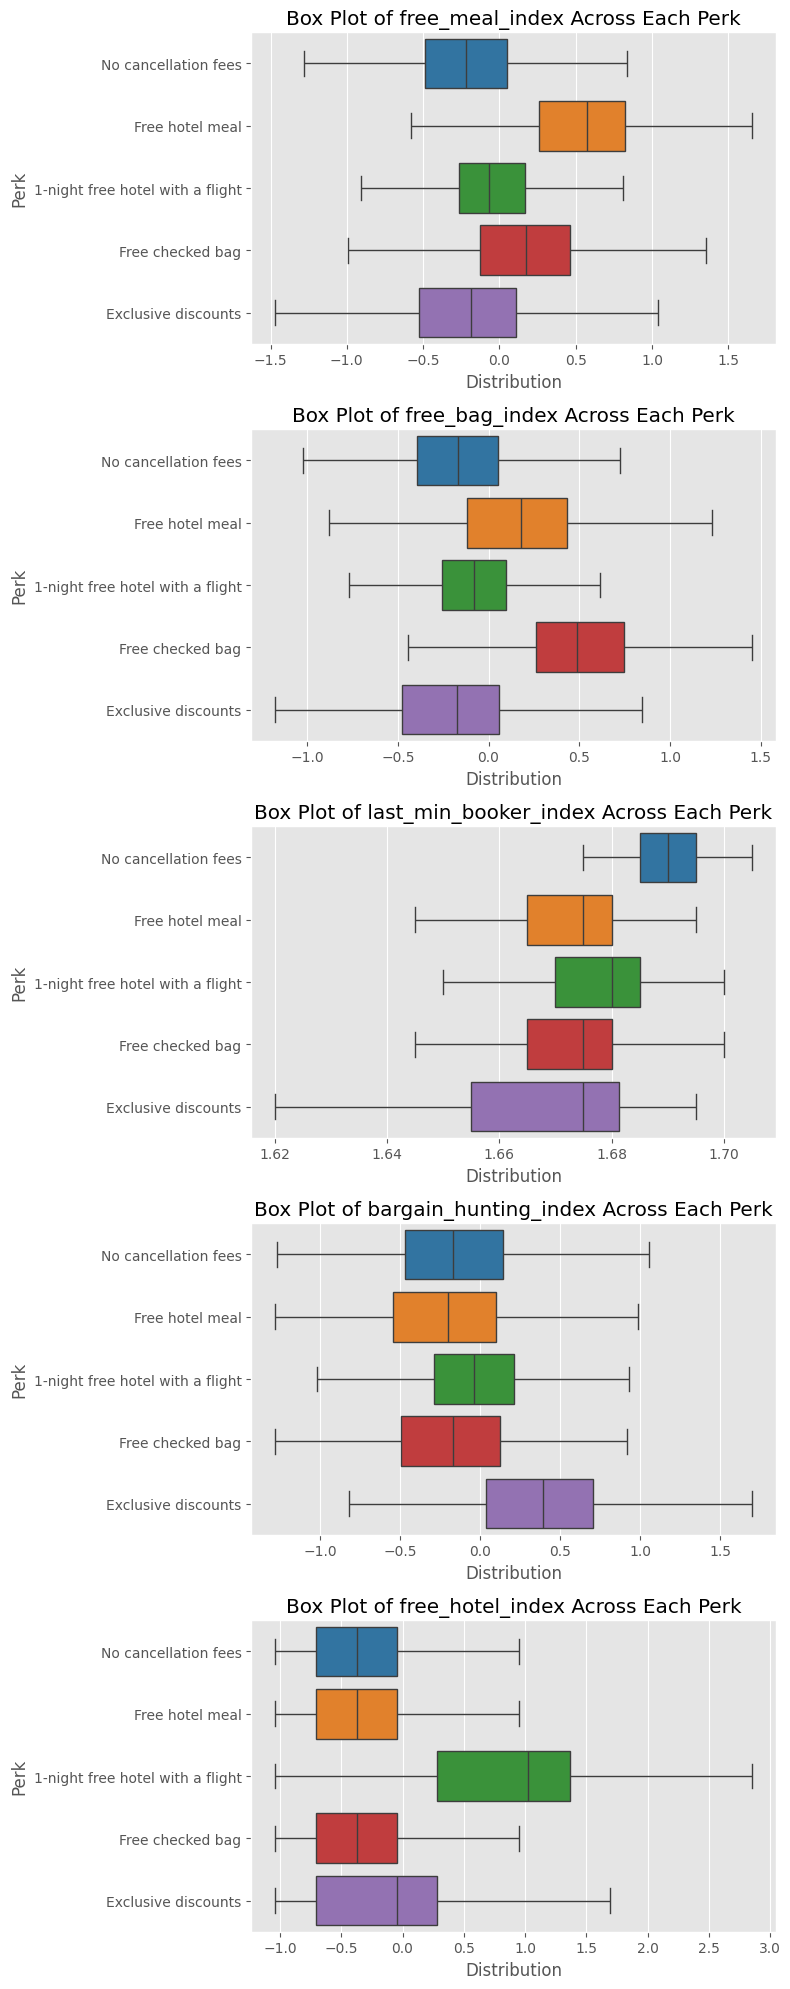

In [ ]:
# Calculate the number of rows and columns for the subplot grid
n_rows = len(index_columns)  # One row per feature
n_cols = 1  # One column per row

# Create subplots with explicit layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 4 * len(index_columns)))

# Loop through each feature to create box plots for each segment
for i, index in enumerate(index_columns):
    sns.boxplot(x=index, y='segment_label', data=cohort_users, ax=axes[i], palette='tab10', showfliers=False)

    axes[i].set_title(f'Box Plot of {index} Across Each Perk')
    axes[i].set_xlabel('Distribution')
    axes[i].set_ylabel('Perk')

plt.tight_layout()
plt.show()

Upon reviewing the distribution of each feature across the different perks, and checking the associated feature for each perk, we can observe that some of the segments are well-defined. Specifically, the perks that stand out are **1-night free hotel with a flight** and **Exclusive Discounts**. The Free **Checked Bag** and **Free Hotel Meal** are performing moderately well, however, the **No Cancellation Fees** has a significant overlap with other perks.

**Key Takeaway:**

Overlaps could be an opportunity for bundling perks or creating tiered reward programs. By understanding this overlap, we can more effectively tailor our rewards program to meet diverse customer needs, potentially increasing customer satisfaction and loyalty.

## Exploratory Data Analysis for Segmentation

Before moving on to the final step and export the customer segmentation csv file, it's crucial to perform some EDA to better understand the segmentation. This will help in validating the data and ensuring that the segments align with the proposed perks. It will also serve as a basis for providing evidence-based insights.

**Distribution of Customers Across Different Segments:**

First, let's plot a bar chart to visualize how many customers belong to each segment. This will give us an overall idea of the segmentation distribution.

<ipython-input-221-0ff358be03b5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of Customers', y='Segment', data=segment_count, palette='coolwarm')


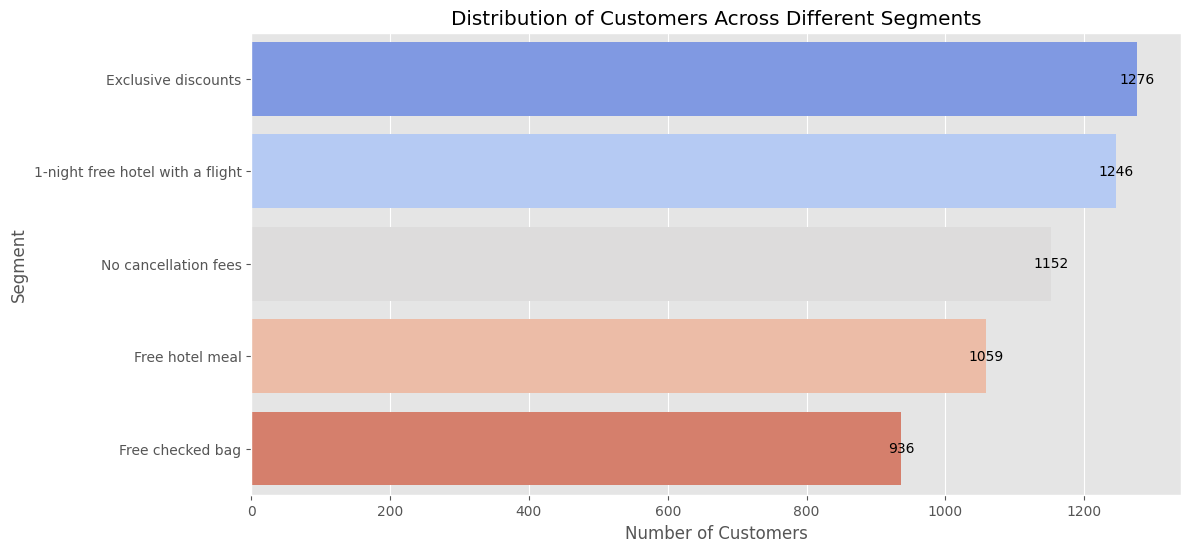

In [ ]:
# Count the number of customers in each segment
segment_count = cohort_users['segment_label'].value_counts().reset_index()
segment_count.columns = ['Segment', 'Number of Customers']

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Number of Customers', y='Segment', data=segment_count, palette='coolwarm')
plt.title('Distribution of Customers Across Different Segments')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')

# Annotate bars with count values
for index, value in enumerate(segment_count['Number of Customers']):
    plt.text(value, index, str(value), ha='center', va='center', fontsize=10, color='black')

#plt.tight_layout()
plt.show()

The bar chart above shows the distribution of customers across different segments based on the perks they are most likely to value. The segments are:


*   **Exclusive Discounts:** This segment has the highest number of customers, suggesting that a significant portion of our customer base are price-sensitive and would appreciate exclusive discounts.

*   **1-night Free Hotel with a Flight:** Closely following the first segment, suggesting a significant number of frequent flyers who would appreciate a free hotel stay.
*   **No Cancellation Fees:** This is the third-largest segment, suggesting that flexibility in cancellation is highly valued by a significant portion of the customer base.


*   **Free Hotel Meal:** This segment shows that a considerable number of customers value a free hotel meal as an attractive perk.


*   **Free Checked Bag:** The smallest segment, but not by a large margin, indicates that many travelers consider baggage costs when booking flights and would value a perk that offers free checked bags.


This distribution aligns well with the Marketing team's proposed perks, suggesting that each proposed perk targets a significant customer segment.


I'll also plot the donut chart to use it later in my presentation:

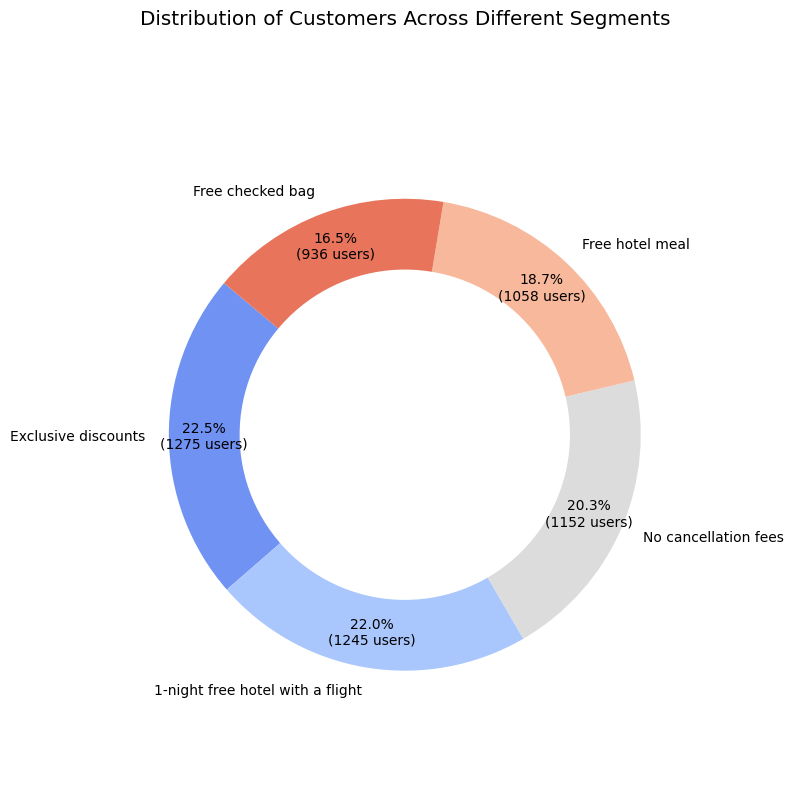

In [ ]:
# Function to format the pie chart labels
def func(pct, allvalues):
    absolute = int(pct/100. * np.sum(allvalues))
    return "{:.1f}%\n({:d} users)".format(pct, absolute)

# Data to plot
sizes = segment_count['Number of Customers']
labels = segment_count['Segment']
colors = sns.color_palette('coolwarm', len(labels))

# Plotting the Pie chart
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, colors=colors, autopct=lambda pct: func(pct, sizes), startangle=140, pctdistance=0.85)

# Drawing center circle for 'Donut' style
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Use the y parameter to adjust the position of the title
plt.title('Distribution of Customers Across Different Segments', y=1.08)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
plt.show()


**Average Age Across Segments:**

Next, let's plot the average age of customers in each segment to see if certain perks are more appealing to different age groups.

<ipython-input-223-66ca8c36f609>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Average Age', y='Segment', data=avg_age_segment, palette='coolwarm')


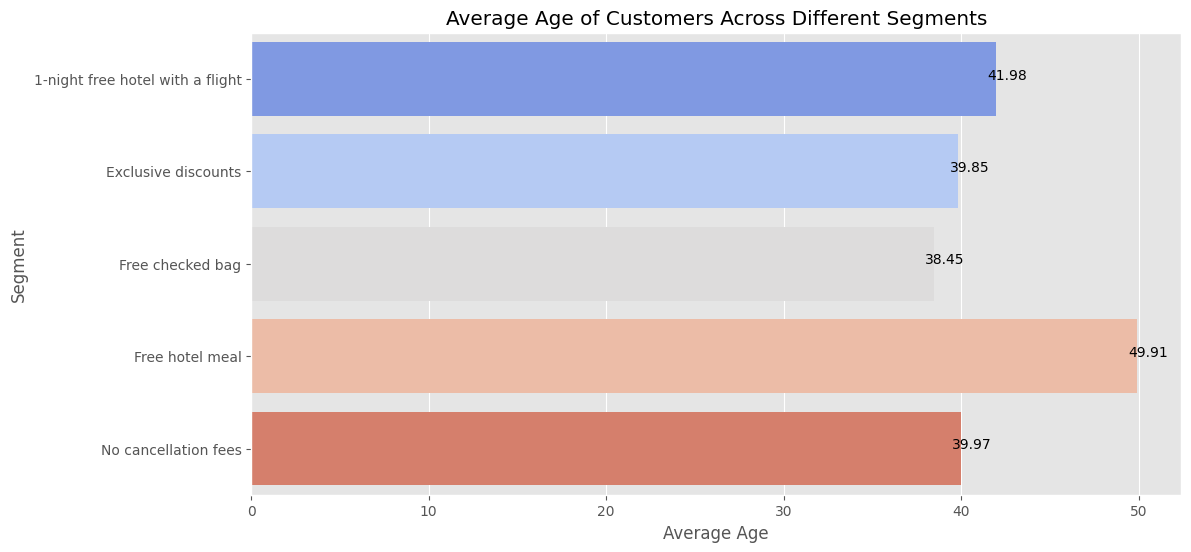

In [ ]:
# Calculate the average age for each segment
avg_age_segment = cohort_users.groupby('segment_label')['age'].mean().reset_index()
avg_age_segment.columns = ['Segment', 'Average Age']

# Plotting the bar chart for average age
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Average Age', y='Segment', data=avg_age_segment, palette='coolwarm')

# Annotate the average age of each segment
for index, value in enumerate(avg_age_segment['Average Age']):
    ax.text(value - 0.5, index, str(round(value, 2)))

plt.title('Average Age of Customers Across Different Segments')
plt.xlabel('Average Age')
plt.ylabel('Segment')
plt.show()

The bar chart displays the average age of customers across different segments. As we can see the average age in all segments are very close to each other.



*   **Free Hotel Meal:** This segment has the highest average age, suggesting that older customers may find a free hotel meal more appealing. No surprise when we used age in the index calculation.
*   **1-night Free Hotel with a Flight:** This segment has the second-highest average age.

*   **No cancellation fee and Exclusive Discounts:** These segments have the lowest average ages, suggesting that younger, might value flexibility in their travel plans and are more budget travellers.


This information could be valuable for targeted marketing and customization of perk offers.

**Gender Distribution Across Segments:**

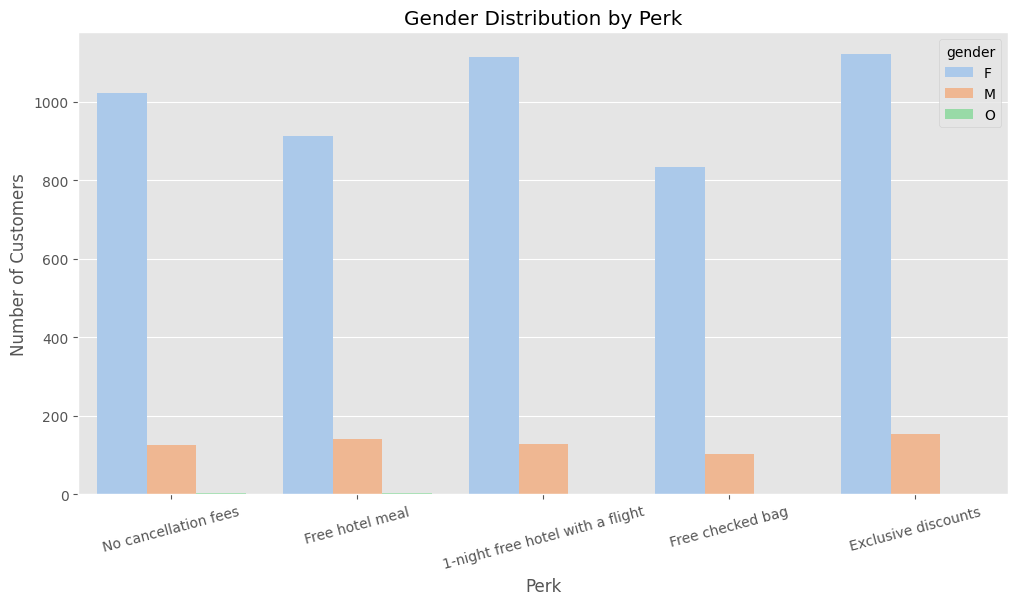

In [ ]:
# Gender analysis: drawing the countplot for gender distribution across different perks using
plt.figure(figsize=(12, 6))
sns.countplot(data=cohort_users, x='segment_label', hue='gender', palette="pastel")
plt.title('Gender Distribution by Perk')
plt.xlabel('Perk')
plt.ylabel('Number of Customers')
plt.xticks(rotation=15)
plt.show()


The gender distribution across the five perks shows a consistent trend: **the number of females is higher across all perks**. This suggests that the proposed perks are more frequently aligned with female customers in our dataset.

This gender disparity may reflect the broader user base and could be significant for tailoring marketing messages or further refining the perks to appeal to a more balanced audience.


**Geographical Analysis:**

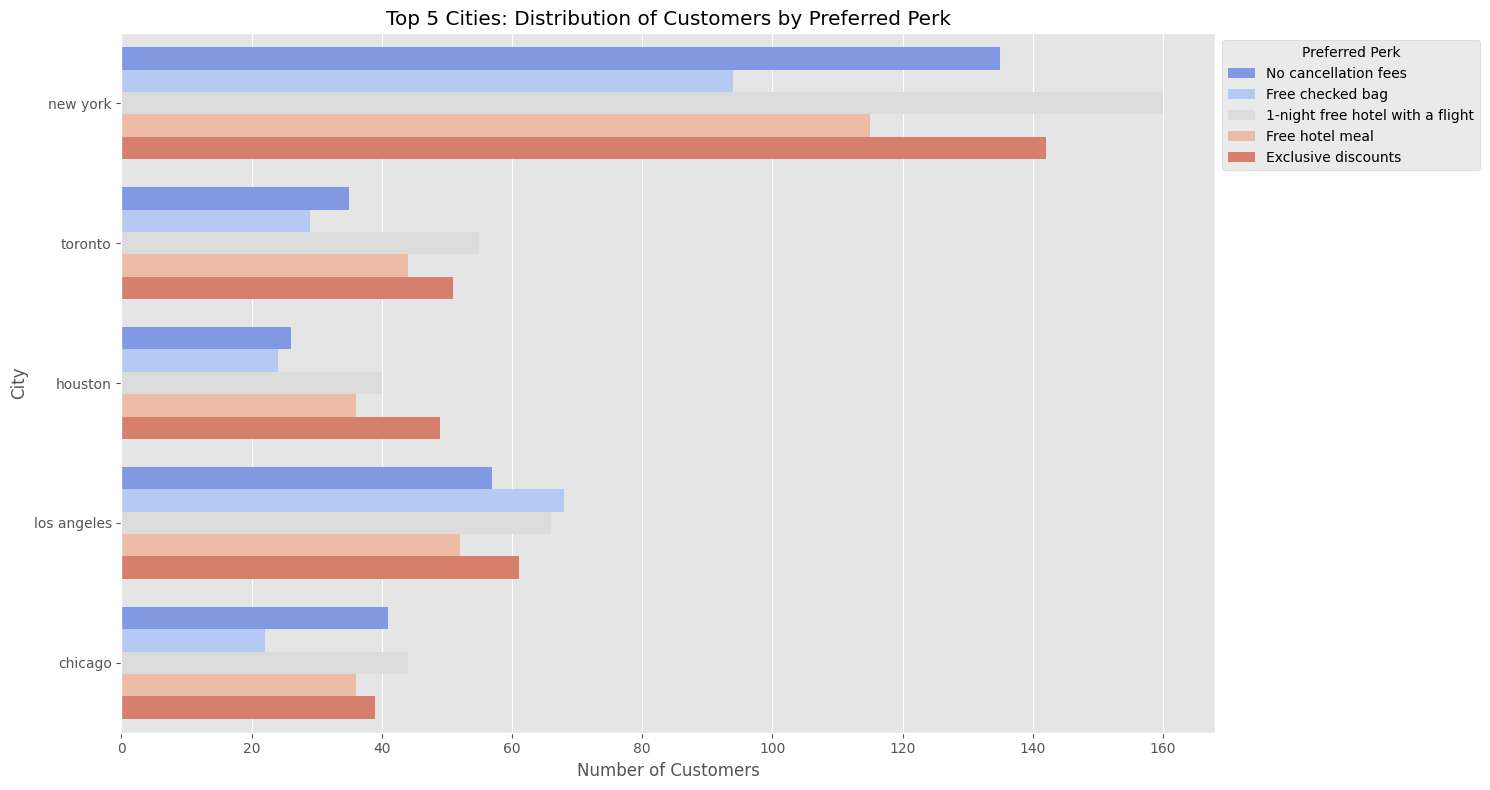

In [ ]:
# Plotting the distribution of customers across top 5 cities and their most preferred perk
top_5_cities = cohort_users['home_city'].value_counts().nlargest(5).index.tolist()

# Filter the data to only include the top 5 cities
top_5_cities_data = cohort_users[cohort_users['home_city'].isin(top_5_cities)]

# Generate a horizontal bar chart for the top 5 cities
plt.figure(figsize=(15, 8))
sns.countplot(data=top_5_cities_data, y='home_city', hue='segment_label', palette="coolwarm")
plt.title('Top 5 Cities: Distribution of Customers by Preferred Perk')
plt.xlabel('Number of Customers')
plt.ylabel('City')
plt.legend(title='Preferred Perk', bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Step 1: Identify the top 5 cities
top_5_cities = cohort_users['home_city'].value_counts().nlargest(5).index.tolist()

# Step 2: Filter the data to include only the top 5 cities
top_5_cities_data = cohort_users[cohort_users['home_city'].isin(top_5_cities)]

# Step 3: Create a pivot table
pivot_table = top_5_cities_data.pivot_table(index='home_city', columns='segment_label', aggfunc='size', fill_value=0)

# Reset the index to turn the index into a column
pivot_table.reset_index(inplace=True)

# Step 4: Export the pivot table to Excel
pivot_table.to_excel('top_5_cities_preferred_perk_distribution.xlsx', index=False)


The horizontal bar chart illustrates the distribution of customers based on their preferred perks within the top 5 cities.


*   **New York City:** The chart shows that "1-night Free Hotel with a Flight" is the most popular perk among customers, followed by "Exclusive Discounts" and "No cancellation fees."

*   **Toronto**: Same as New Your City, "1-night Free Hotel with a Flight" and "Exclusive Discounts" are the dominant perks, with "Free hotel meal" also having a noticeable presence.

*   **Houston:** "Exclusive Discounts" is the most popular, followed by "1-night Free Hotel with a Flight" and "Free hotel meal."

*   **Los Angeles:** The city shows a strong preference for "Free checked bag," followed by "1-night Free Hotel with a Flight."

*   **Chicago:** "1-night Free Hotel with a Flight" is the most popular perk, also "No Cancellation Fees" and "Exclusive discounts" almost have an equal number of customers, indicating a split preference for these two perks.

## Customer Segmentation Analysis and Next Steps


The overlap in high index values across multiple perks suggests that while we have segmented users based on their highest preference, many customers have secondary preferences that are also strong. This is a valuable insight as it provides us an opportunity to think beyond a one-perk-per-customer model.


For instance, a tiered or rotating set of perks could be considered in future phases of the rewards program. This would allow us to cater to these secondary preferences, thereby enhancing customer satisfaction and engagement with the rewards program.

**Key Insights:**

**1. User Preferences Align with Proposed Perks**
The segmentation reveals that the Marketing team's proposed perks resonate well with specific customer behaviors. The highest affinity segments are "Exclusive Discounts" and "1-night Free Hotel with a Flight," with more than 1,200 customers each, showing that there's a large customer base that would appreciate these perks.

**2. Polarizing Perks Capture Varied Customer Interests**
The index distributions for "No Cancellation Fees" and "Free hotel meal" are wider, indicating greater variability in customer affinity for these perks. This means that some customers highly value these options, while others do not. For example, customers who book travel far in advance may not see the value in a "No Cancellation Fees" perk. This polarizing nature isn't necessarily bad; it allows us to capture a wider range of customer interests.

**3. Overlap in Perk Preferences**
While each user is assigned to only one segment, the index values indicate that many users have relatively high scores in multiple perks. This suggests that while we segment users based on their highest preference, they may also be interested in other perks, which provides an opportunity for cross-promotion or tiered reward systems.

**4. Opportunity for More Customized Offerings**
The segmentation suggests that we have an opportunity to offer more nuanced perks based on the secondary preferences of our customers, allowing us to create a more compelling rewards program over time.

**Recommendations:**
**1. Launch Pilot Programs for Top Segments**
Begin with a pilot program targeting the customers in the "Exclusive Discounts" and "1-night Free Hotel with a Flight" segments, as they are the largest groups.

**2. Consider Tiered or Rotating Perks**
Given the overlap in perk preferences, consider offering a tiered or rotating set of perks that allow customers to choose from a small selection every few months. This would let us cater to secondary preferences and keep the rewards program fresh.

**3. Performance Monitoring:**
Keep an eye on KPIs such as engagement rate, conversion rate, and customer lifetime value to measure the success of these personalized campaigns.

**4. Explore Partnerships for Exclusive Discounts**
Since "Exclusive Discounts" has a broad distribution, consider partnerships with airlines or hotels to offer limited-time discounts, appealing to those with a high affinity for this perk.

**5. Optimize for Seasonal Variability**
Consider the seasonality aspect in travel bookings to offer targeted perks. For instance, "1-night free hotel with a flight" could be more appealing during peak travel seasons.

**6. Periodic Re-segmentation**
Customer preferences can change over time. Periodically updating these segments will keep our marketing efforts aligned with customer needs.

With these insights, we are now ready to finalize our segmented list of customers, each assigned to the perk they are most likely to appreciate. This data will serve as the foundation for the pilot phase of our rewards program. We'll now proceed to export the segmented data to a CSV file, which will include each customer's user_id and their respective segment label. This will be invaluable for downstream marketing activities.

In [ ]:
final_segmentation_df = cohort_users[['user_id','segment_label']]

# Save the DataFrame to a CSV file
final_segmentation_df.to_csv('TravelTide_Customer_Segmentation.csv', index=False)

# Display the first few rows of the final DataFrame
final_segmentation_df.head()

,user_id,segment_label
0,23557,No cancellation fees
1,94883,Free hotel meal
2,101961,1-night free hotel with a flight
3,149058,Free checked bag
4,152583,Free checked bag
